## 作業

1. 如何使用已經訓練好的模型？
2. 依照 https://github.com/qqwweee/keras-yolo3 的程式碼，請敘述，訓練模型時，資料集的格式是什麼？具體一點的說，要提供什麼格式的文件來描述資料集的圖片以及 bboxes 的信息呢？





In [1]:
import tensorflow as tf
import os
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

Using TensorFlow backend.


In [2]:
if not os.path.exists("2020_train.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
  import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
  from os import getcwd

  sets=[('2020', 'train')]

  # Pascal VOC 的資料類別
  classes = ["bean", "defective bean"]

  # 把 annotation 轉換訓練時需要的資料形態
  def convert_annotation(year, image_id, list_file):
      in_file = open('VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
      tree=ET.parse(in_file)
      root = tree.getroot()

      for obj in root.iter('object'):
          difficult = obj.find('difficult').text
          cls = obj.find('name').text
          if cls not in classes or int(difficult)==1:
              continue
          cls_id = classes.index(cls)
          xmlbox = obj.find('bndbox')
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
          list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

  wd = "."

  for year, image_set in sets:
      image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
      annotation_path = '%s_%s.txt'%(year, image_set)
      list_file = open(annotation_path, 'w')
      print("save annotation at %s" % annotation_path)
      for image_id in image_ids: 
          list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
          convert_annotation(year, image_id, list_file)
          list_file.write('\n')
      list_file.close()

save annotation at 2020_train.txt


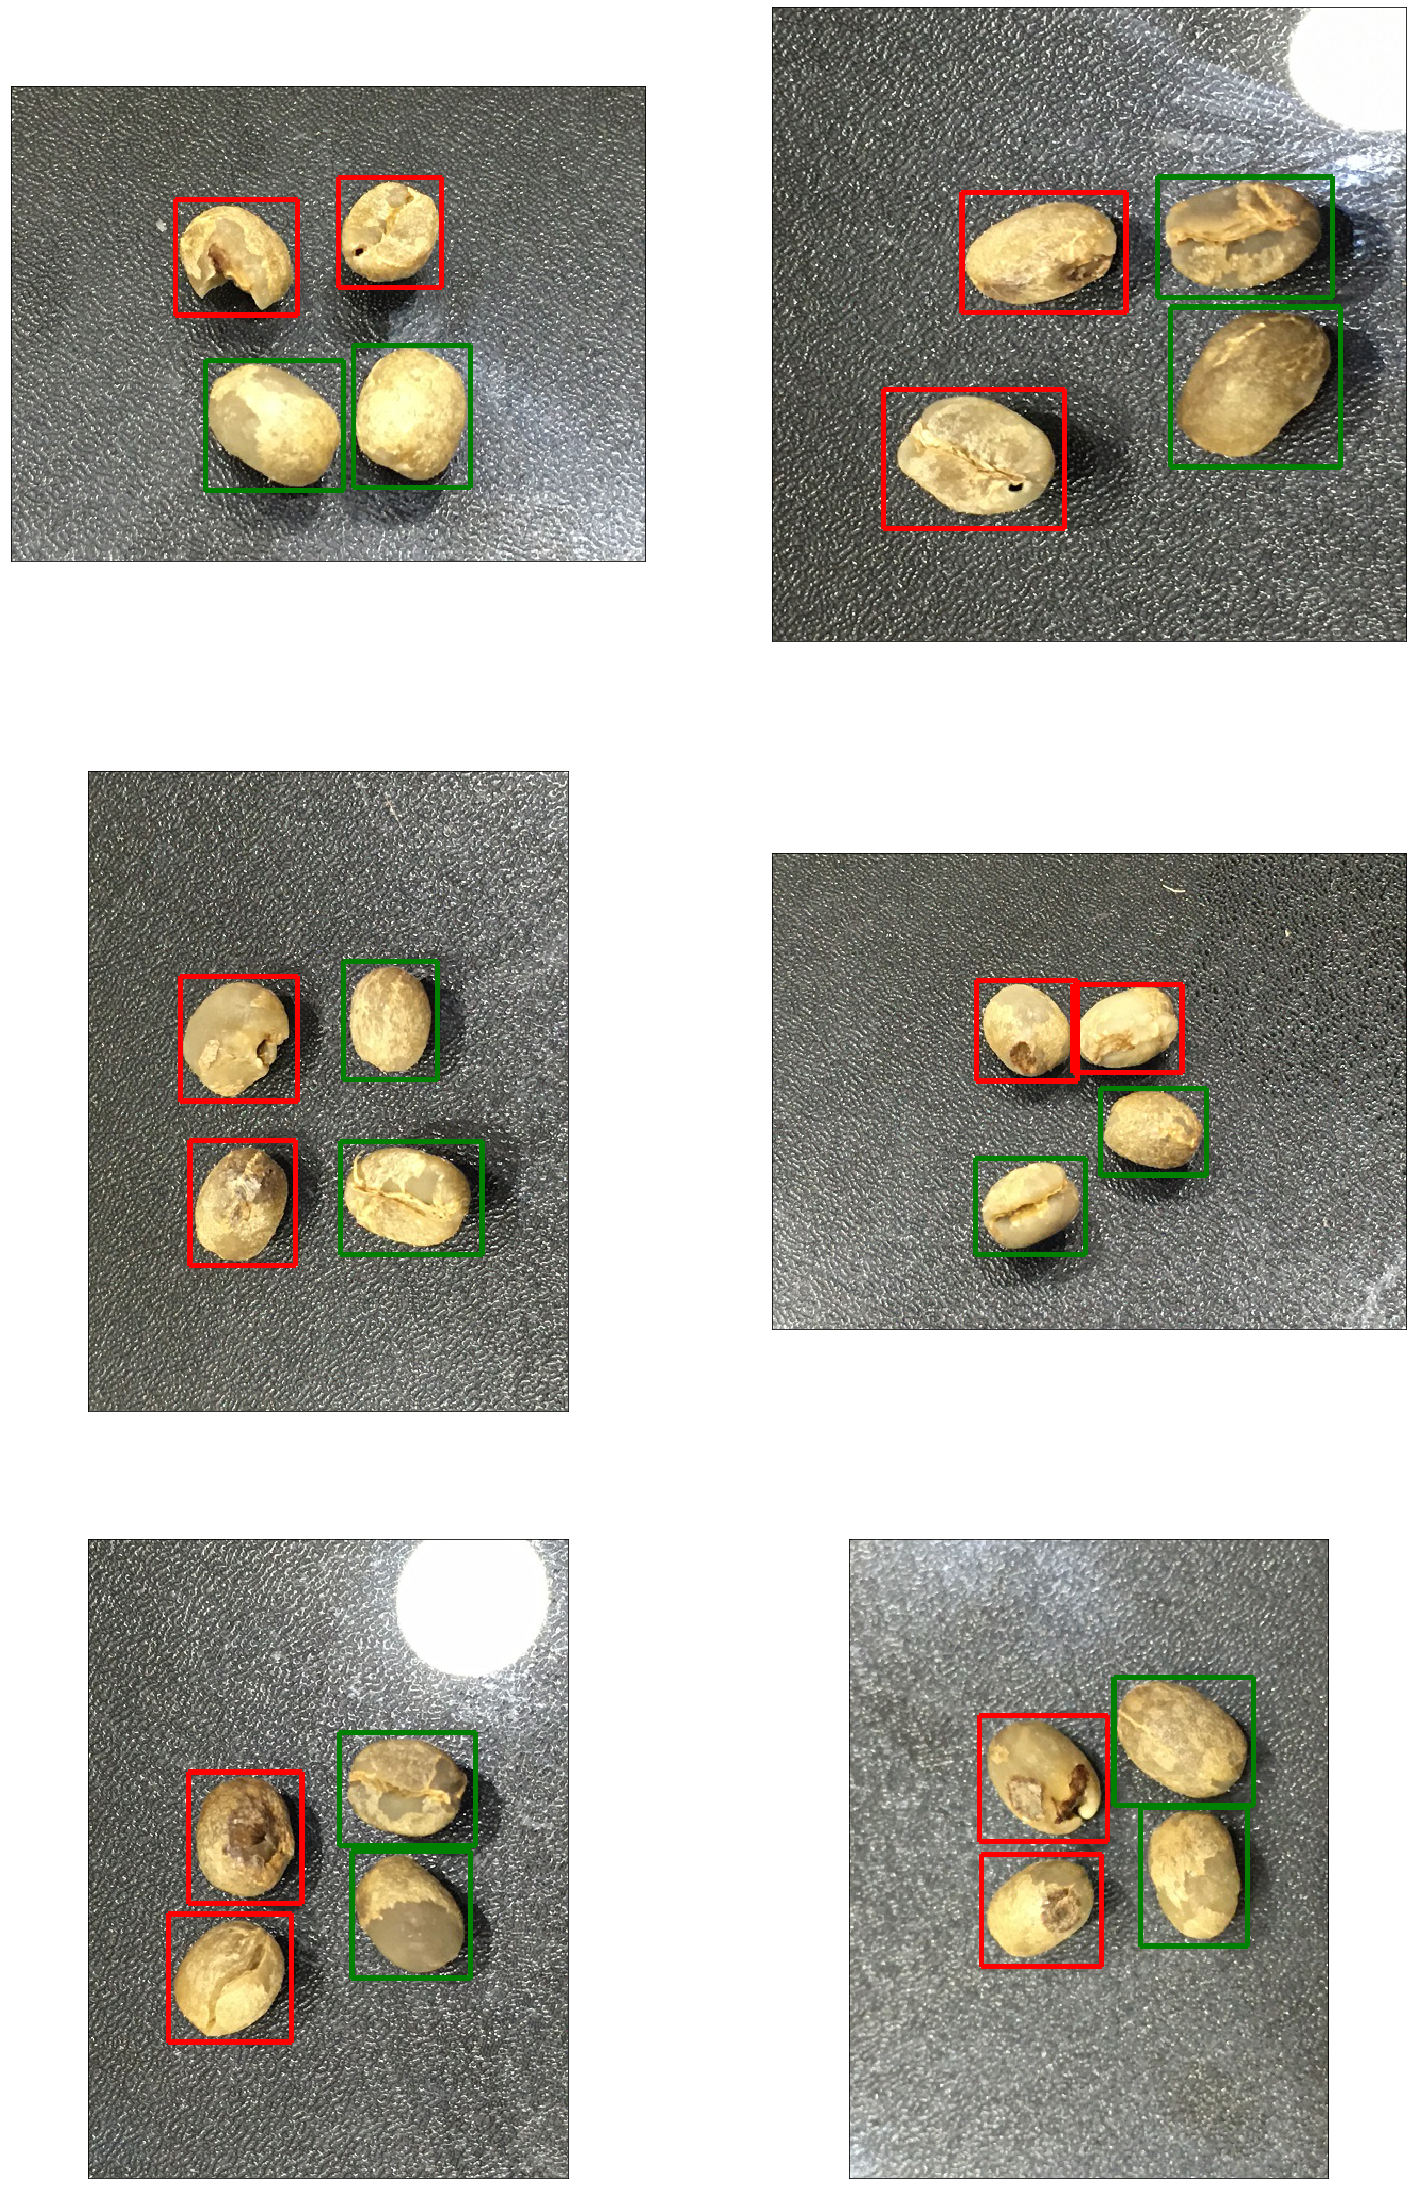

In [3]:
with open('2020_train.txt') as f:
    train_lines = f.readlines()
fig = plt.figure(figsize=(25,40))
for i in range(6):
    line = train_lines[i].split()
    image = Image.open(line[0])
    boxs = np.array([np.array(list(map(int,boxs.split(',')))) for boxs in line[1:]])
    draw = ImageDraw.Draw(image)
    for j in range(boxs.shape[0]):
        if boxs[j,4]==1:
            top, left, bottom, right,label = boxs[j]
            draw.line(((top,left),(top,right),(bottom,right),(bottom,left),(top,left)), fill="red", width=5)
        else:
            top, left, bottom, right,label = boxs[j]
            draw.line(((top,left),(top,right),(bottom,right),(bottom,left),(top,left)), fill="green", width=5)
    ax = fig.add_subplot(3, 2, i + 1, xticks=[], yticks=[])
    plt.imshow(image)

In [4]:
class YOLO_Kmeans:

    def __init__(self, cluster_number, filename):
        self.cluster_number = cluster_number
        self.filename = "2020_train.txt"

    def iou(self, boxes, clusters):  # 1 box -> k clusters
        n = boxes.shape[0]
        k = self.cluster_number

        box_area = boxes[:, 0] * boxes[:, 1]
        box_area = box_area.repeat(k)
        box_area = np.reshape(box_area, (n, k))

        cluster_area = clusters[:, 0] * clusters[:, 1]
        cluster_area = np.tile(cluster_area, [1, n])
        cluster_area = np.reshape(cluster_area, (n, k))

        box_w_matrix = np.reshape(boxes[:, 0].repeat(k), (n, k))
        cluster_w_matrix = np.reshape(np.tile(clusters[:, 0], (1, n)), (n, k))
        min_w_matrix = np.minimum(cluster_w_matrix, box_w_matrix)

        box_h_matrix = np.reshape(boxes[:, 1].repeat(k), (n, k))
        cluster_h_matrix = np.reshape(np.tile(clusters[:, 1], (1, n)), (n, k))
        min_h_matrix = np.minimum(cluster_h_matrix, box_h_matrix)
        inter_area = np.multiply(min_w_matrix, min_h_matrix)

        result = inter_area / (box_area + cluster_area - inter_area)
        return result

    def avg_iou(self, boxes, clusters):
        accuracy = np.mean([np.max(self.iou(boxes, clusters), axis=1)])
        return accuracy

    def kmeans(self, boxes, k, dist=np.median):
        box_number = boxes.shape[0]
        distances = np.empty((box_number, k))
        last_nearest = np.zeros((box_number,))
        np.random.seed()
        clusters = boxes[np.random.choice(
            box_number, k, replace=False)]  # init k clusters
        while True:

            distances = 1 - self.iou(boxes, clusters)

            current_nearest = np.argmin(distances, axis=1)
            if (last_nearest == current_nearest).all():
                break  # clusters won't change
            for cluster in range(k):
                clusters[cluster] = dist(  # update clusters
                    boxes[current_nearest == cluster], axis=0)

            last_nearest = current_nearest

        return clusters

    def result2txt(self, data):
        f = open("yolo_anchors.txt", 'w')
        row = np.shape(data)[0]
        for i in range(row):
            if i == 0:
                x_y = "%d,%d" % (data[i][0], data[i][1])
            else:
                x_y = ", %d,%d" % (data[i][0], data[i][1])
            f.write(x_y)
        f.close()

    def txt2boxes(self):
        f = open(self.filename, 'r')
        dataSet = []
        for line in f:
            infos = line.split(" ")
            length = len(infos)
            for i in range(1, length):
                width = int(infos[i].split(",")[2]) - \
                    int(infos[i].split(",")[0])
                height = int(infos[i].split(",")[3]) - \
                    int(infos[i].split(",")[1])
                dataSet.append([width, height])
        result = np.array(dataSet)
        f.close()
        return result

    def txt2clusters(self):
        all_boxes = self.txt2boxes()
        result = self.kmeans(all_boxes, k=self.cluster_number)
        result = result[np.lexsort(result.T[0, None])]
        self.result2txt(result)
        print("K anchors:\n {}".format(result))
        print("Accuracy: {:.2f}%".format(
            self.avg_iou(all_boxes, result) * 100))


if __name__ == "__main__":
    cluster_number = 9
    filename = "2020_train.txt"
    kmeans = YOLO_Kmeans(cluster_number, filename)
    kmeans.txt2clusters()

K anchors:
 [[109 130]
 [113 115]
 [122 105]
 [128 145]
 [142 170]
 [148 124]
 [159 195]
 [162 148]
 [187 183]]
Accuracy: 89.55%


In [5]:
annotation_path = '2020_train.txt' # 轉換好格式的標註檔案
log_dir = 'model_weight/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/bean_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    freeze_model =model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')















Create YOLOv3 model with 9 anchors and 3 classes.


C:\Users\Jasonhsu\anaconda3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 24) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
C:\Users\Jasonhsu\anaconda3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((24,) vs (255,)).
  weight_values[i].shape))
C:\Users\Jasonhsu\anaconda3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 24) vs (255, 512, 1, 1)).
  weight_values[i].shape))
C:\Users\Jasonhsu\anaconda3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((24,) vs (255,)).
  weight_values[i].shape))
C:\Users\Jasonhsu\anaconda3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for 

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 81 samples, val on 9 samples, with batch size 16.




Epoch 1/50
5/5 [==============================] - 8s 2s/step - loss: 7138.8110 - val_loss: 4712.2612

Epoch 2/50
5/5 [==============================] - 4s 731ms/step - loss: 3886.1679 - val_loss: 2511.4387
Epoch 3/50
5/5 [==============================] - 5s 905ms/step - loss: 2164.3139 - val_loss: 1401.3854
Epoch 4/50
5/5 [==============================] - 3s 586ms/step - loss: 1298.1229 - val_loss: 829.2473
Epoch 5/50
5/5 [==============================] - 3s 596ms/step - loss: 854.9456 - val_loss: 567.3008
Epoch 6/50
5/5 [==============================] - 3s 601ms/step - loss: 597.4072 - val_loss: 405.8649
Epoch 7/50
5/5 [==============================] - 3s 600ms/step - loss: 444.4133 - val_loss: 312.4043
Epoch 8/50
5/5 [================

In [6]:
# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 6 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    final_modal=model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=200,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Unfreeze all of the layers.
Train on 81 samples, val on 9 samples, with batch size 6.
Epoch 51/200
13/13 [==============================] - 13s 994ms/step - loss: 44.0132 - val_loss: 38.5065
Epoch 52/200
13/13 [==============================] - 5s 373ms/step - loss: 33.7002 - val_loss: 32.4146
Epoch 53/200
13/13 [==============================] - 5s 371ms/step - loss: 30.3604 - val_loss: 28.2951
Epoch 54/200
13/13 [==============================] - 5s 372ms/step - loss: 28.3499 - val_loss: 27.6135
Epoch 55/200
13/13 [==============================] - 5s 377ms/step - loss: 26.2740 - val_loss: 22.3583
Epoch 56/200
13/13 [==============================] - 5s 378ms/step - loss: 25.3099 - val_loss: 26.3356
Epoch 57/200
13/13 [==============================] - 5s 372ms/step - loss: 25.8062 - val_loss: 25.7707
Epoch 58/200
13/13 [==============================] - 5s 374ms/step - loss: 24.7619 - val_loss: 25.9156
Epoch 59/200
13/13 [==============================] - 5s 372ms/step - loss: 24.57

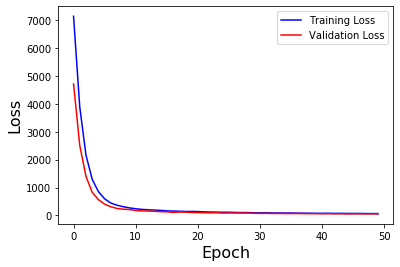

In [7]:
#第一階段使用作者預訓練權重遷移學習
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.plot(freeze_model.history['loss'], color='b', label='Training Loss')
plt.plot(freeze_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

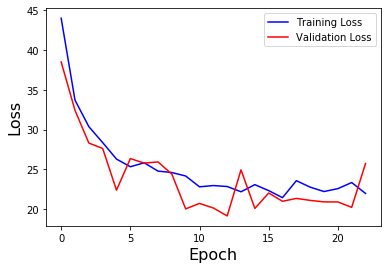

In [8]:
#第二階段解棟訓練完整網絡
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.plot(final_modal.history['loss'], color='b', label='Training Loss')
plt.plot(final_modal.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [ ]:
from yolo import YOLO
classes_path = 'model_data/bean_classes.txt'
log_dir = 'model_weight/' # 訓練好的模型儲存的路徑
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

image_list=[]
for img in range(10) :
  image_list.append('VOCdevkit/VOC2020/JPEGImages/test' + str(img+1) +'.JPG')

for idx, im in enumerate(image_list) :
    r_image = yolo_model.detect_image(Image.open(im))  
    display(r_image)

In [11]:
import time
import cv2
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

def detect_video(yolo, video_path, output_path=""):
    import cv2
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    # 指定 video 編碼方式(此例使用 MP4)
    video_FourCC = cv2.VideoWriter_fourcc(*'MP4V')
    video_fps       = vid.get(cv2.CAP_PROP_FPS) 
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    isOutput = True if output_path != "" else False
    if isOutput:
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
    video_cnt = 0  
    video_playtime = []  
    while True:
        return_value, frame = vid.read()
        video_cnt += 1 
        if return_value == True : 
            image = Image.fromarray(frame)
            start_time = time.time() 
            image = yolo.detect_image(image)
            end_time = time.time()
            time_img = end_time - start_time  
            video_playtime.append(round(time_img, 3)) 
            result = np.asarray(image)
            cv2.putText(result, text='fps', org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.50, color=(255, 0, 0), thickness=2)
            if isOutput:
                out.write(result)
        else :  
            break
    vid.release()  # release vid resource
    out.release()  # release out resource
    return video_playtime, video_cnt 

# 1.偵測生豆影片.mp4
video_playtime, video_cnt = detect_video(yolo_model, video_path="VIDEO_BEAN.mp4", output_path="VIDEO_BEAN_detect.mp4")
print('VIDEO_BEAN.mp4 total frames: ', video_cnt)  # 總共有多少 frames

# 平均 fps :
avg_fps = 1/np.mean(video_playtime)
print("VIDEO_BEAN.mp4 avg fps: %.3f" % avg_fps)

model_weight/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 6 boxes for img
bean 0.33 (326, 773) (594, 1032)
bean 0.73 (34, 664) (245, 802)
bean 0.81 (418, 215) (593, 371)
bean 0.86 (513, 400) (740, 568)
bean 0.90 (1042, 18) (1372, 245)
bean 0.91 (191, 420) (533, 594)
1.939374499999758
(416, 416, 3)
Found 8 boxes for img
bean 0.36 (0, 0) (188, 242)
bean 0.47 (326, 800) (587, 1034)
bean 0.60 (199, 85) (527, 271)
bean 0.61 (441, 218) (572, 389)
bean 0.62 (47, 657) (234, 817)
bean 0.89 (1041, 16) (1372, 265)
bean 0.89 (194, 426) (533, 603)
bean 0.93 (518, 414) (746, 573)
0.05447249999997439
(416, 416, 3)
Found 7 boxes for img
bean 0.33 (48, 666) (235, 829)
bean 0.44 (0, 0) (183, 258)
bean 0.59 (207, 103) (523, 266)
bean 0.66 (308, 825) (611, 1031)
bean 0.87 (1041, 26) (1370, 276)
bean 0.88 (200, 437) (527, 609)
bean 0.92 (505, 424) (756, 587)
0.049865800000588933
(416, 416, 3)
Found 7 boxes for img
bean 0.43 (0, 0) (190, 294)
bean 0.58 (411, 293) (609, 37

(416, 416, 3)
Found 9 boxes for img
defective bean 0.39 (376, 114) (594, 299)
bean 0.34 (12, 812) (307, 1013)
bean 0.46 (378, 415) (668, 564)
bean 0.52 (0, 146) (265, 430)
bean 0.71 (376, 114) (594, 299)
bean 0.76 (249, 297) (511, 442)
bean 0.78 (265, 563) (509, 796)
bean 0.82 (1043, 200) (1381, 453)
bean 0.87 (505, 597) (776, 743)
0.05560140000034153
(416, 416, 3)
Found 10 boxes for img
defective bean 0.41 (373, 115) (592, 315)
bean 0.38 (134, 0) (345, 215)
bean 0.41 (0, 137) (251, 459)
bean 0.51 (391, 427) (657, 573)
bean 0.64 (209, 566) (555, 819)
bean 0.67 (253, 308) (506, 451)
bean 0.68 (8, 822) (314, 1011)
bean 0.68 (373, 115) (592, 315)
bean 0.79 (516, 604) (770, 750)
bean 0.87 (1060, 225) (1368, 445)
0.05817709999973886
(416, 416, 3)
Found 10 boxes for img
defective bean 0.31 (375, 122) (589, 320)
bean 0.32 (0, 123) (247, 485)
bean 0.38 (128, 0) (357, 231)
bean 0.42 (520, 589) (774, 764)
bean 0.63 (407, 428) (644, 583)
bean 0.67 (261, 309) (501, 458)
bean 0.69 (375, 122) (589, 

Found 10 boxes for img
bean 0.33 (177, 0) (361, 466)
bean 0.46 (398, 298) (650, 432)
bean 0.53 (510, 129) (717, 297)
bean 0.59 (1094, 376) (1406, 587)
bean 0.60 (283, 739) (576, 913)
bean 0.61 (147, 135) (413, 303)
bean 0.73 (546, 725) (832, 910)
bean 0.83 (301, 461) (559, 588)
bean 0.85 (447, 581) (683, 707)
bean 0.92 (0, 329) (271, 565)
0.0565323000000717
(416, 416, 3)
Found 9 boxes for img
bean 0.38 (153, 126) (410, 324)
bean 0.38 (253, 768) (604, 915)
bean 0.45 (521, 121) (707, 321)
bean 0.45 (401, 299) (647, 447)
bean 0.53 (559, 708) (820, 938)
bean 0.67 (1107, 388) (1395, 593)
bean 0.72 (319, 473) (545, 590)
bean 0.84 (462, 588) (673, 719)
bean 0.89 (0, 333) (268, 573)
0.05451489999995829
(416, 416, 3)
Found 7 boxes for img
bean 0.33 (422, 282) (631, 482)
bean 0.45 (321, 484) (540, 589)
bean 0.48 (527, 119) (705, 338)
bean 0.59 (256, 784) (608, 914)
bean 0.69 (0, 320) (279, 594)
bean 0.75 (1077, 415) (1451, 600)
bean 0.80 (479, 596) (667, 731)
0.05304679999971995
(416, 416, 3)
Fo

(416, 416, 3)
Found 12 boxes for img
defective bean 0.31 (407, 71) (553, 542)
bean 0.45 (407, 71) (553, 542)
bean 0.46 (155, 875) (367, 1005)
bean 0.66 (333, 176) (634, 435)
bean 0.67 (126, 405) (473, 649)
bean 0.67 (710, 210) (939, 377)
bean 0.68 (449, 820) (809, 1011)
bean 0.75 (609, 342) (846, 553)
bean 0.80 (511, 533) (743, 673)
bean 0.81 (790, 25) (1090, 263)
bean 0.85 (1314, 480) (1626, 654)
bean 0.87 (653, 641) (884, 812)
0.05857120000018767
(416, 416, 3)
Found 11 boxes for img
bean 0.38 (404, 62) (572, 546)
bean 0.47 (147, 868) (393, 1010)
bean 0.58 (614, 347) (847, 536)
bean 0.66 (327, 195) (660, 413)
bean 0.67 (809, 16) (1086, 269)
bean 0.72 (728, 199) (940, 391)
bean 0.72 (453, 825) (819, 1011)
bean 0.81 (528, 535) (752, 673)
bean 0.83 (1313, 463) (1666, 678)
bean 0.84 (149, 410) (465, 645)
bean 0.84 (673, 648) (875, 803)
0.054103200000099605
(416, 416, 3)
Found 12 boxes for img
bean 0.33 (400, 51) (585, 557)
bean 0.40 (771, 768) (1052, 1026)
bean 0.42 (150, 878) (408, 998)


bean 0.48 (1656, 449) (1876, 669)
bean 0.69 (776, 532) (1021, 677)
bean 0.71 (628, 175) (900, 435)
bean 0.73 (1013, 204) (1231, 379)
bean 0.75 (879, 332) (1158, 563)
bean 0.78 (1090, 21) (1391, 252)
bean 0.88 (704, 814) (1114, 1032)
bean 0.90 (932, 626) (1182, 826)
bean 0.91 (385, 424) (748, 634)
0.057269300000371004
(416, 416, 3)
Found 12 boxes for img
defective bean 0.33 (899, 336) (1157, 534)
bean 0.42 (390, 851) (676, 1037)
bean 0.53 (1043, 772) (1356, 1026)
bean 0.60 (1665, 444) (1905, 663)
bean 0.60 (899, 336) (1157, 534)
bean 0.73 (1022, 176) (1258, 391)
bean 0.75 (706, 817) (1130, 1015)
bean 0.77 (1122, 41) (1417, 222)
bean 0.80 (653, 182) (906, 421)
bean 0.83 (786, 522) (1051, 674)
bean 0.90 (941, 637) (1199, 802)
bean 0.92 (370, 421) (785, 634)
0.058556599999974424
(416, 416, 3)
Found 11 boxes for img
bean 0.38 (406, 860) (681, 1020)
bean 0.57 (705, 820) (1160, 1006)
bean 0.57 (1695, 430) (1883, 669)
bean 0.71 (914, 347) (1186, 518)
bean 0.72 (1035, 151) (1275, 396)
bean 0.72

(416, 416, 3)
Found 12 boxes for img
defective bean 0.31 (1294, 129) (1480, 340)
bean 0.42 (611, 823) (898, 1015)
bean 0.46 (131, 173) (340, 412)
bean 0.49 (1348, 0) (1700, 248)
bean 0.55 (1294, 129) (1480, 340)
bean 0.57 (1169, 293) (1397, 506)
bean 0.69 (886, 181) (1139, 348)
bean 0.69 (1245, 598) (1382, 767)
bean 0.82 (1034, 471) (1280, 634)
bean 0.89 (1285, 788) (1608, 964)
bean 0.91 (622, 405) (980, 581)
bean 0.94 (967, 805) (1335, 981)
0.060358499999892956
(416, 416, 3)
Found 11 boxes for img
defective bean 0.36 (1181, 285) (1407, 514)
bean 0.36 (1295, 132) (1499, 336)
bean 0.39 (1363, 0) (1712, 249)
bean 0.41 (899, 200) (1139, 328)
bean 0.55 (621, 827) (899, 1009)
bean 0.56 (1181, 285) (1407, 514)
bean 0.65 (147, 172) (336, 426)
bean 0.85 (630, 405) (983, 584)
bean 0.86 (1032, 476) (1299, 635)
bean 0.87 (1296, 801) (1610, 962)
bean 0.94 (972, 805) (1351, 986)
0.062248100000033446
(416, 416, 3)
Found 10 boxes for img
defective bean 0.33 (1178, 297) (1429, 500)
bean 0.32 (1260, 57

Found 11 boxes for img
defective bean 0.42 (1385, 318) (1649, 496)
bean 0.35 (1511, 118) (1754, 357)
bean 0.37 (820, 874) (1076, 1009)
bean 0.62 (1385, 318) (1649, 496)
bean 0.65 (309, 165) (513, 444)
bean 0.71 (1505, 809) (1845, 981)
bean 0.73 (1112, 196) (1361, 341)
bean 0.79 (1165, 820) (1582, 1012)
bean 0.87 (1233, 502) (1521, 651)
bean 0.88 (1404, 662) (1681, 757)
bean 0.95 (806, 405) (1229, 616)
0.05657569999948464
(416, 416, 3)
Found 11 boxes for img
defective bean 0.49 (1386, 318) (1665, 495)
bean 0.38 (1104, 209) (1381, 323)
bean 0.45 (1492, 818) (1876, 969)
bean 0.47 (818, 828) (1125, 1061)
bean 0.48 (1537, 126) (1757, 347)
bean 0.52 (312, 166) (520, 438)
bean 0.58 (1386, 318) (1665, 495)
bean 0.72 (1387, 612) (1733, 797)
bean 0.74 (1166, 830) (1600, 1003)
bean 0.88 (1230, 507) (1544, 652)
bean 0.93 (802, 407) (1246, 615)
0.05649219999941124
(416, 416, 3)
Found 9 boxes for img
defective bean 0.40 (1396, 326) (1672, 486)
bean 0.43 (310, 173) (531, 428)
bean 0.52 (1551, 117) (1

(416, 416, 3)
Found 8 boxes for img
defective bean 0.36 (1634, 329) (1896, 560)
bean 0.31 (1634, 329) (1896, 560)
bean 0.46 (1042, 435) (1487, 666)
bean 0.53 (208, 0) (441, 163)
bean 0.73 (1341, 170) (1659, 430)
bean 0.74 (1687, 621) (1910, 858)
bean 0.74 (1456, 847) (1814, 1080)
bean 0.82 (522, 217) (736, 471)
0.05394069999965723
(416, 416, 3)
Found 8 boxes for img
bean 0.38 (1651, 324) (1911, 563)
bean 0.44 (1707, 627) (1900, 857)
bean 0.54 (220, 0) (445, 159)
bean 0.62 (1475, 513) (1805, 732)
bean 0.78 (1361, 171) (1667, 436)
bean 0.80 (1498, 849) (1795, 1080)
bean 0.84 (536, 231) (739, 463)
bean 0.86 (1073, 427) (1487, 677)
0.05054259999997157
(416, 416, 3)
Found 10 boxes for img
bean 0.31 (1086, 899) (1363, 1079)
bean 0.35 (0, 478) (179, 678)
bean 0.44 (24, 197) (172, 399)
bean 0.46 (229, 0) (460, 158)
bean 0.47 (1669, 324) (1897, 557)
bean 0.63 (1488, 521) (1821, 725)
bean 0.73 (1392, 181) (1659, 425)
bean 0.78 (1501, 855) (1814, 1077)
bean 0.80 (536, 234) (755, 464)
bean 0.87 (1

Found 4 boxes for img
bean 0.51 (172, 556) (402, 786)
bean 0.77 (530, 0) (771, 176)
bean 0.84 (244, 293) (442, 434)
bean 0.85 (851, 296) (1132, 530)
0.047619200000553974
(416, 416, 3)
Found 5 boxes for img
bean 0.45 (1533, 530) (1916, 750)
bean 0.51 (151, 542) (456, 805)
bean 0.67 (534, 0) (776, 172)
bean 0.85 (249, 291) (452, 433)
bean 0.86 (856, 302) (1135, 527)
0.04952450000018871
(416, 416, 3)
Found 5 boxes for img
bean 0.51 (1547, 540) (1916, 742)
bean 0.62 (560, 0) (783, 165)
bean 0.65 (157, 543) (462, 806)
bean 0.81 (257, 283) (452, 437)
bean 0.85 (858, 310) (1139, 518)
0.049852399999508634
(416, 416, 3)
Found 5 boxes for img
bean 0.58 (1557, 537) (1920, 739)
bean 0.75 (559, 0) (790, 186)
bean 0.75 (173, 547) (460, 803)
bean 0.81 (870, 307) (1137, 520)
bean 0.83 (261, 279) (459, 434)
0.050385800000185554
(416, 416, 3)
Found 5 boxes for img
bean 0.56 (1564, 539) (1920, 733)
bean 0.73 (270, 270) (454, 439)
bean 0.78 (183, 545) (461, 806)
bean 0.79 (559, 0) (796, 195)
bean 0.85 (87

Found 4 boxes for img
bean 0.36 (528, 686) (917, 854)
bean 0.61 (1280, 379) (1699, 613)
bean 0.83 (945, 21) (1311, 203)
bean 0.85 (679, 359) (883, 533)
0.0469784000006257
(416, 416, 3)
Found 3 boxes for img
bean 0.79 (1311, 363) (1694, 630)
bean 0.81 (688, 359) (909, 535)
bean 0.87 (963, 22) (1317, 210)
0.047052899999471265
(416, 416, 3)
Found 4 boxes for img
bean 0.69 (710, 346) (905, 548)
bean 0.76 (614, 654) (903, 912)
bean 0.82 (1340, 366) (1685, 635)
bean 0.89 (976, 30) (1326, 211)
0.04742809999970632
(416, 416, 3)
Found 4 boxes for img
bean 0.79 (719, 355) (922, 550)
bean 0.81 (1368, 371) (1682, 634)
bean 0.86 (637, 670) (912, 894)
bean 0.88 (1001, 37) (1323, 219)
0.046976900000117894
(416, 416, 3)
Found 4 boxes for img
bean 0.74 (1390, 374) (1681, 637)
bean 0.80 (751, 347) (921, 562)
bean 0.84 (1011, 34) (1336, 231)
bean 0.87 (645, 691) (924, 886)
0.0482226999993145
(416, 416, 3)
Found 5 boxes for img
defective bean 0.31 (752, 352) (946, 562)
bean 0.44 (1379, 400) (1740, 631)
be

Found 2 boxes for img
bean 0.32 (1329, 854) (1600, 1044)
bean 0.77 (1405, 486) (1672, 757)
0.04781439999987924
(416, 416, 3)
Found 2 boxes for img
bean 0.32 (0, 539) (201, 930)
bean 0.65 (1421, 503) (1667, 738)
0.0444231999999829
(416, 416, 3)
Found 4 boxes for img
bean 0.32 (0, 557) (205, 896)
bean 0.41 (1534, 26) (1748, 210)
bean 0.46 (1321, 831) (1673, 1071)
bean 0.47 (1420, 489) (1693, 750)
0.04603109999970911
(416, 416, 3)
Found 3 boxes for img
bean 0.47 (1544, 22) (1750, 211)
bean 0.68 (1344, 836) (1674, 1054)
bean 0.73 (1437, 509) (1690, 708)
0.04535130000022036
(416, 416, 3)
Found 3 boxes for img
bean 0.61 (1560, 0) (1752, 228)
bean 0.74 (1356, 840) (1685, 1049)
bean 0.88 (1467, 503) (1695, 711)
0.04595739999967918
(416, 416, 3)
Found 4 boxes for img
bean 0.33 (0, 567) (236, 892)
bean 0.41 (1578, 0) (1769, 230)
bean 0.70 (1387, 843) (1669, 1042)
bean 0.86 (1482, 498) (1704, 713)
0.046341600000232575
(416, 416, 3)
Found 3 boxes for img
bean 0.60 (0, 590) (249, 860)
bean 0.68 (13

Found 4 boxes for img
defective bean 0.41 (428, 374) (661, 601)
bean 0.65 (428, 374) (661, 601)
bean 0.83 (471, 812) (673, 973)
bean 0.87 (289, 536) (533, 741)
0.04813430000012886
(416, 416, 3)
Found 3 boxes for img
bean 0.73 (469, 797) (681, 974)
bean 0.78 (435, 391) (675, 584)
bean 0.86 (304, 546) (523, 727)
0.04630799999995361
(416, 416, 3)
Found 5 boxes for img
defective bean 0.35 (443, 380) (675, 586)
bean 0.31 (343, 484) (486, 790)
bean 0.49 (475, 780) (686, 976)
bean 0.61 (443, 380) (675, 586)
bean 0.74 (296, 543) (538, 720)
0.04912320000039472
(416, 416, 3)
Found 4 boxes for img
defective bean 0.33 (444, 385) (689, 579)
bean 0.54 (467, 788) (727, 968)
bean 0.60 (444, 385) (689, 579)
bean 0.61 (295, 547) (556, 720)
0.051134799999999814
(416, 416, 3)
Found 4 boxes for img
defective bean 0.32 (458, 390) (689, 562)
bean 0.43 (298, 555) (568, 707)
bean 0.44 (458, 390) (689, 562)
bean 0.79 (490, 796) (727, 966)
0.051307700000506884
(416, 416, 3)
Found 2 boxes for img
bean 0.34 (349, 

(416, 416, 3)
Found 5 boxes for img
defective bean 0.37 (792, 449) (1152, 701)
bean 0.36 (872, 890) (1127, 1057)
bean 0.47 (173, 0) (338, 147)
bean 0.58 (792, 449) (1152, 701)
bean 0.67 (637, 578) (1004, 887)
0.05313470000055531
(416, 416, 3)
Found 4 boxes for img
defective bean 0.39 (824, 450) (1136, 702)
bean 0.51 (177, 10) (361, 138)
bean 0.58 (824, 450) (1136, 702)
bean 0.86 (648, 585) (1015, 896)
0.050088099999811675
(416, 416, 3)
Found 4 boxes for img
defective bean 0.35 (848, 459) (1136, 704)
bean 0.31 (187, 21) (366, 135)
bean 0.59 (848, 459) (1136, 704)
bean 0.89 (664, 622) (1020, 867)
0.05098850000013044
(416, 416, 3)
Found 3 boxes for img
defective bean 0.43 (873, 461) (1126, 709)
bean 0.48 (873, 461) (1126, 709)
bean 0.87 (660, 630) (1041, 864)
0.04749240000001009
(416, 416, 3)
Found 3 boxes for img
defective bean 0.55 (888, 446) (1138, 743)
bean 0.34 (888, 446) (1138, 743)
bean 0.82 (718, 649) (999, 851)
0.04891559999941819
(416, 416, 3)
Found 1 boxes for img
bean 0.32 (69

Found 3 boxes for img
defective bean 0.41 (710, 174) (1008, 435)
bean 0.62 (710, 174) (1008, 435)
bean 0.84 (666, 442) (882, 666)
0.04834019999998418
(416, 416, 3)
Found 4 boxes for img
defective bean 0.56 (729, 177) (1014, 430)
bean 0.46 (47, 826) (191, 1080)
bean 0.56 (729, 177) (1014, 430)
bean 0.79 (665, 458) (901, 646)
0.05013719999988098
(416, 416, 3)
Found 4 boxes for img
defective bean 0.37 (730, 177) (1057, 423)
bean 0.46 (54, 847) (191, 1062)
bean 0.50 (637, 469) (936, 623)
bean 0.76 (745, 194) (1018, 400)
0.049758899999687856
(416, 416, 3)
Found 3 boxes for img
defective bean 0.38 (741, 175) (1055, 411)
bean 0.54 (57, 859) (195, 1045)
bean 0.65 (741, 175) (1055, 411)
0.0485342000001765
(416, 416, 3)
Found 3 boxes for img
defective bean 0.38 (752, 176) (1064, 394)
bean 0.63 (752, 176) (1064, 394)
bean 0.66 (36, 870) (219, 1035)
0.04810859999997774
(416, 416, 3)
Found 4 boxes for img
defective bean 0.45 (776, 166) (1056, 390)
bean 0.51 (667, 403) (998, 657)
bean 0.52 (776, 166

bean 0.42 (1101, 286) (1368, 469)
bean 0.70 (363, 724) (655, 876)
0.047834200000579585
(416, 416, 3)
Found 1 boxes for img
bean 0.73 (349, 722) (709, 878)
0.04356019999977434
(416, 416, 3)
Found 2 boxes for img
bean 0.62 (1183, 46) (1514, 209)
bean 0.79 (351, 701) (720, 891)
0.04472369999984949
(416, 416, 3)
Found 2 boxes for img
bean 0.70 (376, 690) (707, 895)
bean 0.71 (1221, 35) (1488, 210)
0.046396000000640925
(416, 416, 3)
Found 4 boxes for img
defective bean 0.32 (389, 700) (710, 878)
bean 0.67 (1113, 220) (1443, 516)
bean 0.67 (389, 700) (710, 878)
bean 0.78 (1247, 16) (1478, 223)
0.04820259999996779
(416, 416, 3)
Found 3 boxes for img
bean 0.67 (1139, 238) (1429, 490)
bean 0.76 (397, 707) (721, 869)
bean 0.79 (1254, 23) (1497, 212)
0.04524259999925562
(416, 416, 3)
Found 3 boxes for img
bean 0.66 (1149, 263) (1432, 461)
bean 0.75 (1267, 24) (1506, 210)
bean 0.80 (401, 707) (737, 862)
0.04854799999975512
(416, 416, 3)
Found 4 boxes for img
defective bean 0.34 (418, 704) (741, 85

Found 5 boxes for img
defective bean 0.33 (692, 808) (1061, 962)
bean 0.41 (1612, 0) (1920, 336)
bean 0.46 (240, 551) (445, 705)
bean 0.70 (692, 808) (1061, 962)
bean 0.91 (1513, 333) (1839, 540)
0.04876019999937853
(416, 416, 3)
Found 6 boxes for img
defective bean 0.31 (242, 566) (451, 702)
defective bean 0.36 (703, 807) (1053, 971)
bean 0.36 (256, 491) (428, 772)
bean 0.54 (242, 566) (451, 702)
bean 0.63 (703, 807) (1053, 971)
bean 0.89 (1515, 336) (1845, 546)
0.05173529999956372
(416, 416, 3)
Found 7 boxes for img
defective bean 0.30 (251, 492) (434, 781)
defective bean 0.32 (706, 804) (1054, 977)
defective bean 0.35 (253, 572) (442, 706)
bean 0.34 (251, 492) (434, 781)
bean 0.52 (253, 572) (442, 706)
bean 0.54 (706, 804) (1054, 977)
bean 0.90 (1515, 338) (1849, 546)
0.053785299999617564
(416, 416, 3)
Found 5 boxes for img
defective bean 0.33 (252, 572) (444, 709)
bean 0.34 (1608, 7) (1920, 311)
bean 0.52 (663, 807) (1122, 973)
bean 0.54 (252, 572) (444, 709)
bean 0.87 (1513, 345) 

Found 2 boxes for img
bean 0.47 (1536, 504) (1675, 826)
bean 0.65 (1016, 41) (1306, 355)
0.04809800000020914
(416, 416, 3)
Found 3 boxes for img
bean 0.40 (358, 0) (588, 129)
bean 0.60 (725, 453) (1082, 681)
bean 0.60 (177, 88) (454, 280)
0.04546299999947223
(416, 416, 3)
Found 4 boxes for img
defective bean 0.36 (732, 444) (1092, 709)
bean 0.48 (375, 0) (588, 138)
bean 0.61 (732, 444) (1092, 709)
bean 0.74 (206, 123) (437, 273)
0.04776219999985187
(416, 416, 3)
Found 5 boxes for img
defective bean 0.45 (751, 431) (1087, 740)
bean 0.43 (751, 431) (1087, 740)
bean 0.45 (1512, 567) (1754, 854)
bean 0.62 (391, 6) (591, 151)
bean 0.81 (227, 129) (425, 292)
0.052048200000172073
(416, 416, 3)
Found 6 boxes for img
defective bean 0.55 (772, 374) (1072, 810)
bean 0.34 (772, 374) (1072, 810)
bean 0.43 (979, 156) (1376, 369)
bean 0.47 (1531, 595) (1738, 860)
bean 0.47 (392, 25) (600, 152)
bean 0.74 (233, 145) (426, 303)
0.04977679999956308
(416, 416, 3)
Found 4 boxes for img
bean 0.30 (387, 33) 

Found 6 boxes for img
bean 0.50 (1278, 351) (1513, 526)
bean 0.74 (414, 559) (668, 748)
bean 0.74 (1131, 609) (1543, 793)
bean 0.80 (754, 249) (938, 472)
bean 0.86 (62, 257) (283, 450)
bean 0.87 (569, 391) (825, 581)
0.0486854000000676
(416, 416, 3)
Found 6 boxes for img
bean 0.31 (1296, 324) (1521, 583)
bean 0.75 (771, 274) (925, 479)
bean 0.75 (445, 571) (650, 748)
bean 0.87 (83, 257) (282, 465)
bean 0.87 (1160, 628) (1528, 785)
bean 0.87 (589, 394) (817, 602)
0.04842850000022736
(416, 416, 3)
Found 5 boxes for img
bean 0.47 (787, 271) (924, 494)
bean 0.57 (458, 580) (654, 755)
bean 0.87 (584, 413) (831, 615)
bean 0.87 (1198, 629) (1498, 807)
bean 0.88 (96, 273) (289, 470)
0.048191400000177964
(416, 416, 3)
Found 7 boxes for img
bean 0.40 (0, 528) (223, 735)
bean 0.49 (699, 280) (1021, 517)
bean 0.49 (1293, 350) (1543, 595)
bean 0.51 (458, 599) (670, 755)
bean 0.80 (596, 428) (836, 624)
bean 0.85 (104, 299) (300, 459)
bean 0.90 (1208, 632) (1500, 829)
0.05018500000005588
(416, 416, 3

Found 7 boxes for img
bean 0.42 (1600, 109) (1836, 328)
bean 0.53 (74, 53) (272, 297)
bean 0.54 (878, 624) (1203, 816)
bean 0.63 (1327, 0) (1602, 159)
bean 0.73 (354, 228) (584, 397)
bean 0.78 (276, 610) (510, 797)
bean 0.93 (587, 121) (853, 310)
0.05223160000059579
(416, 416, 3)
Found 10 boxes for img
bean 0.31 (761, 783) (997, 910)
bean 0.42 (137, 500) (395, 621)
bean 0.48 (912, 654) (1167, 820)
bean 0.55 (1345, 0) (1589, 170)
bean 0.57 (0, 305) (337, 504)
bean 0.58 (222, 30) (533, 197)
bean 0.73 (78, 84) (271, 281)
bean 0.87 (298, 220) (634, 434)
bean 0.87 (258, 633) (531, 805)
bean 0.91 (580, 133) (863, 320)
0.056521499999689695
(416, 416, 3)
Found 13 boxes for img
defective bean 0.35 (225, 41) (532, 217)
bean 0.38 (273, 538) (508, 933)
bean 0.45 (947, 668) (1136, 828)
bean 0.53 (155, 525) (374, 627)
bean 0.53 (1359, 17) (1570, 159)
bean 0.53 (750, 784) (1006, 940)
bean 0.56 (225, 41) (532, 217)
bean 0.73 (0, 339) (318, 497)
bean 0.75 (74, 95) (271, 306)
bean 0.80 (1596, 131) (1851

(416, 416, 3)
Found 12 boxes for img
defective bean 0.37 (242, 307) (507, 447)
bean 0.41 (1279, 230) (1560, 434)
bean 0.47 (1392, 31) (1734, 225)
bean 0.54 (828, 15) (1038, 160)
bean 0.65 (258, 286) (470, 463)
bean 0.69 (274, 862) (509, 1021)
bean 0.70 (14, 579) (300, 717)
bean 0.76 (396, 68) (609, 230)
bean 0.80 (85, 354) (266, 539)
bean 0.81 (288, 507) (625, 668)
bean 0.92 (1559, 430) (1776, 606)
bean 0.93 (576, 399) (834, 576)
0.05685249999987718
(416, 416, 3)
Found 13 boxes for img
defective bean 0.48 (270, 308) (482, 451)
bean 0.44 (257, 775) (510, 1080)
bean 0.53 (1411, 11) (1680, 243)
bean 0.57 (1279, 262) (1553, 430)
bean 0.58 (268, 291) (460, 471)
bean 0.67 (832, 14) (1030, 166)
bean 0.69 (273, 870) (509, 1025)
bean 0.70 (27, 587) (287, 728)
bean 0.70 (402, 56) (603, 255)
bean 0.75 (101, 363) (246, 546)
bean 0.79 (304, 521) (604, 668)
bean 0.87 (1559, 434) (1768, 614)
bean 0.95 (570, 416) (840, 582)
0.05727290000049834
(416, 416, 3)
Found 14 boxes for img
defective bean 0.41 (

Found 10 boxes for img
defective bean 0.54 (192, 379) (412, 523)
bean 0.47 (203, 358) (381, 538)
bean 0.61 (1457, 509) (1670, 685)
bean 0.63 (1168, 328) (1505, 510)
bean 0.70 (355, 149) (506, 311)
bean 0.72 (222, 580) (537, 741)
bean 0.78 (10, 409) (206, 626)
bean 0.87 (1326, 105) (1585, 282)
bean 0.87 (713, 31) (997, 236)
bean 0.93 (492, 475) (755, 655)
0.056203199999799835
(416, 416, 3)
Found 11 boxes for img
defective bean 0.50 (186, 380) (417, 526)
bean 0.33 (1445, 506) (1669, 694)
bean 0.38 (0, 633) (235, 808)
bean 0.52 (194, 361) (388, 543)
bean 0.59 (217, 592) (531, 736)
bean 0.63 (349, 153) (506, 317)
bean 0.77 (12, 415) (198, 626)
bean 0.78 (1203, 327) (1438, 513)
bean 0.88 (1329, 108) (1567, 290)
bean 0.88 (708, 23) (997, 255)
bean 0.93 (476, 481) (767, 663)
0.0549338999999236
(416, 416, 3)
Found 10 boxes for img
defective bean 0.43 (183, 364) (383, 547)
bean 0.30 (1432, 513) (1652, 693)
bean 0.53 (3, 430) (185, 616)
bean 0.53 (183, 364) (383, 547)
bean 0.68 (258, 609) (462, 

Found 5 boxes for img
bean 0.62 (0, 611) (256, 793)
bean 0.65 (99, 208) (249, 361)
bean 0.68 (905, 337) (1184, 582)
bean 0.69 (251, 500) (464, 714)
bean 0.83 (1131, 541) (1433, 752)
0.049277299999630486
(416, 416, 3)
Found 7 boxes for img
defective bean 0.35 (79, 212) (248, 358)
bean 0.34 (1026, 104) (1285, 395)
bean 0.38 (451, 91) (680, 269)
bean 0.55 (0, 580) (249, 818)
bean 0.58 (79, 212) (248, 358)
bean 0.78 (1127, 540) (1421, 748)
bean 0.90 (248, 530) (453, 682)
0.05131919999985257
(416, 416, 3)
Found 8 boxes for img
defective bean 0.33 (45, 216) (266, 345)
bean 0.35 (1101, 552) (1390, 707)
bean 0.37 (434, 75) (676, 278)
bean 0.38 (45, 216) (266, 345)
bean 0.50 (0, 552) (222, 841)
bean 0.52 (1035, 107) (1270, 366)
bean 0.73 (913, 351) (1117, 566)
bean 0.93 (219, 519) (458, 693)
0.05146899999999732
(416, 416, 3)
Found 8 boxes for img
defective bean 0.34 (61, 201) (216, 350)
bean 0.37 (423, 50) (658, 301)
bean 0.46 (1002, 89) (1274, 381)
bean 0.50 (61, 201) (216, 350)
bean 0.60 (171

(416, 416, 3)
Found 8 boxes for img
defective bean 0.33 (1548, 130) (1777, 346)
bean 0.34 (1118, 181) (1450, 549)
bean 0.48 (1530, 110) (1784, 392)
bean 0.54 (506, 367) (833, 584)
bean 0.56 (128, 91) (356, 295)
bean 0.70 (1351, 503) (1611, 709)
bean 0.79 (670, 177) (915, 353)
bean 0.82 (778, 547) (1042, 736)
0.05602709999948274
(416, 416, 3)
Found 7 boxes for img
bean 0.43 (1507, 118) (1774, 386)
bean 0.45 (115, 24) (350, 359)
bean 0.55 (1112, 181) (1460, 551)
bean 0.68 (739, 546) (1061, 742)
bean 0.70 (1348, 519) (1581, 691)
bean 0.73 (524, 389) (787, 562)
bean 0.77 (664, 164) (903, 372)
0.05038630000035482
(416, 416, 3)
Found 7 boxes for img
defective bean 0.38 (523, 385) (770, 574)
bean 0.33 (118, 60) (337, 324)
bean 0.51 (1124, 189) (1444, 541)
bean 0.65 (523, 385) (770, 574)
bean 0.71 (727, 566) (1026, 724)
bean 0.79 (639, 166) (908, 375)
bean 0.83 (1333, 519) (1575, 696)
0.05155950000062148
(416, 416, 3)
Found 8 boxes for img
defective bean 0.35 (1500, 159) (1723, 364)
bean 0.45 

Found 9 boxes for img
defective bean 0.33 (373, 198) (597, 396)
defective bean 0.35 (1053, 578) (1288, 741)
defective bean 0.42 (1254, 182) (1455, 393)
defective bean 0.43 (244, 408) (478, 620)
bean 0.43 (446, 584) (760, 809)
bean 0.54 (1254, 182) (1455, 393)
bean 0.66 (244, 408) (478, 620)
bean 0.70 (373, 198) (597, 396)
bean 0.83 (1053, 578) (1288, 741)
0.05736680000063643
(416, 416, 3)
Found 4 boxes for img
bean 0.57 (1231, 208) (1463, 369)
bean 0.72 (355, 182) (588, 412)
bean 0.78 (227, 423) (470, 618)
bean 0.92 (1012, 582) (1293, 750)
0.047485799999776646
(416, 416, 3)
Found 5 boxes for img
defective bean 0.34 (330, 200) (578, 400)
bean 0.65 (330, 200) (578, 400)
bean 0.69 (427, 628) (709, 782)
bean 0.80 (215, 409) (448, 641)
bean 0.93 (995, 572) (1280, 763)
0.049911799999790674
(416, 416, 3)
Found 6 boxes for img
defective bean 0.35 (328, 194) (539, 421)
bean 0.44 (1206, 188) (1394, 387)
bean 0.60 (328, 194) (539, 421)
bean 0.76 (429, 616) (675, 796)
bean 0.77 (207, 410) (425, 64

(416, 416, 3)
Found 4 boxes for img
defective bean 0.78 (517, 256) (787, 474)
bean 0.38 (1118, 14) (1373, 167)
bean 0.39 (959, 300) (1347, 554)
bean 0.84 (373, 663) (633, 791)
0.0507473999996364
(416, 416, 3)
Found 4 boxes for img
defective bean 0.64 (1284, 861) (1491, 1036)
defective bean 0.76 (473, 262) (809, 470)
bean 0.43 (1128, 25) (1344, 154)
bean 0.85 (363, 668) (621, 790)
0.04891899999984162
(416, 416, 3)
Found 4 boxes for img
defective bean 0.58 (1271, 856) (1475, 1040)
defective bean 0.76 (461, 273) (787, 465)
bean 0.51 (1110, 26) (1339, 153)
bean 0.81 (359, 664) (602, 798)
0.049150599999848055
(416, 416, 3)
Found 3 boxes for img
defective bean 0.56 (1252, 855) (1465, 1038)
defective bean 0.82 (460, 281) (777, 458)
bean 0.81 (334, 658) (609, 806)
0.04982230000041454
(416, 416, 3)
Found 3 boxes for img
defective bean 0.61 (1228, 863) (1466, 1036)
defective bean 0.81 (435, 277) (780, 468)
bean 0.75 (324, 654) (604, 812)
0.04832369999985531
(416, 416, 3)
Found 3 boxes for img
de

defective bean 0.63 (178, 417) (441, 590)
bean 0.55 (97, 727) (259, 892)
bean 0.65 (687, 115) (914, 343)
0.0486561999996411
(416, 416, 3)
Found 6 boxes for img
defective bean 0.33 (90, 732) (258, 897)
defective bean 0.46 (684, 95) (896, 371)
defective bean 0.46 (160, 422) (412, 595)
bean 0.49 (90, 732) (258, 897)
bean 0.52 (684, 95) (896, 371)
bean 0.72 (1377, 403) (1662, 575)
0.05303079999976035
(416, 416, 3)
Found 3 boxes for img
defective bean 0.57 (152, 424) (398, 603)
bean 0.61 (669, 103) (892, 366)
bean 0.69 (1341, 403) (1677, 593)
0.04650590000073862
(416, 416, 3)
Found 4 boxes for img
defective bean 0.62 (158, 437) (375, 602)
bean 0.31 (59, 737) (273, 897)
bean 0.34 (1319, 396) (1663, 622)
bean 0.49 (612, 123) (914, 393)
0.04798600000049191
(416, 416, 3)
Found 5 boxes for img
defective bean 0.36 (640, 146) (827, 394)
defective bean 0.63 (154, 442) (374, 605)
bean 0.37 (1332, 328) (1559, 688)
bean 0.38 (640, 146) (827, 394)
bean 0.60 (1338, 443) (1577, 573)
0.051122400000167545


Found 2 boxes for img
defective bean 0.48 (51, 391) (297, 590)
bean 0.48 (51, 391) (297, 590)
0.04567320000023756
(416, 416, 3)
Found 3 boxes for img
defective bean 0.38 (42, 404) (298, 593)
bean 0.35 (695, 569) (883, 893)
bean 0.58 (42, 404) (298, 593)
0.04723310000008496
(416, 416, 3)
Found 4 boxes for img
defective bean 0.39 (37, 413) (292, 594)
bean 0.45 (667, 659) (918, 820)
bean 0.45 (689, 557) (876, 926)
bean 0.57 (37, 413) (292, 594)
0.04820629999994708
(416, 416, 3)
Found 4 boxes for img
defective bean 0.46 (36, 416) (286, 602)
bean 0.42 (679, 552) (877, 946)
bean 0.51 (36, 416) (286, 602)
bean 0.51 (674, 659) (901, 831)
0.04905210000015359
(416, 416, 3)
Found 3 boxes for img
defective bean 0.37 (41, 429) (276, 605)
bean 0.42 (665, 514) (862, 993)
bean 0.55 (41, 429) (276, 605)
0.047187099999973725
(416, 416, 3)
Found 3 boxes for img
defective bean 0.39 (63, 425) (221, 625)
bean 0.32 (63, 425) (221, 625)
bean 0.45 (696, 636) (819, 897)
0.047255999999833875
(416, 416, 3)
Found 

(416, 416, 3)
Found 3 boxes for img
bean 0.40 (526, 319) (756, 484)
bean 0.45 (1025, 784) (1288, 943)
bean 0.75 (324, 107) (588, 299)
0.04816640000080952
(416, 416, 3)
Found 3 boxes for img
bean 0.44 (992, 790) (1304, 963)
bean 0.64 (318, 121) (586, 305)
bean 0.81 (525, 327) (740, 506)
0.046100599999590486
(416, 416, 3)
Found 4 boxes for img
bean 0.40 (67, 791) (207, 968)
bean 0.45 (971, 783) (1318, 993)
bean 0.62 (341, 109) (531, 335)
bean 0.82 (522, 335) (735, 517)
0.047329699999863806
(416, 416, 3)
Found 3 boxes for img
bean 0.30 (950, 761) (1313, 1018)
bean 0.59 (336, 112) (523, 352)
bean 0.75 (523, 341) (720, 536)
0.046454199999971024
(416, 416, 3)
Found 2 boxes for img
bean 0.52 (505, 343) (728, 565)
bean 0.77 (316, 172) (534, 350)
0.04595719999997527
(416, 416, 3)
Found 3 boxes for img
defective bean 0.37 (297, 192) (547, 362)
bean 0.31 (492, 354) (727, 589)
bean 0.70 (297, 192) (547, 362)
0.04767730000003212
(416, 416, 3)
Found 5 boxes for img
defective bean 0.46 (291, 210) (53

Found 6 boxes for img
defective bean 0.33 (313, 461) (534, 644)
defective bean 0.71 (546, 211) (800, 383)
bean 0.36 (884, 525) (1283, 753)
bean 0.38 (1582, 546) (1870, 795)
bean 0.54 (313, 461) (534, 644)
bean 0.65 (478, 640) (746, 833)
0.054379299999709474
(416, 416, 3)
Found 6 boxes for img
defective bean 0.54 (557, 204) (806, 396)
bean 0.33 (1602, 542) (1870, 805)
bean 0.41 (861, 518) (1300, 768)
bean 0.53 (557, 204) (806, 396)
bean 0.54 (489, 655) (754, 827)
bean 0.65 (323, 480) (543, 635)
0.049891000000570784
(416, 416, 3)
Found 7 boxes for img
defective bean 0.56 (565, 191) (810, 410)
bean 0.31 (519, 523) (712, 960)
bean 0.44 (1620, 538) (1861, 810)
bean 0.49 (852, 510) (1292, 789)
bean 0.54 (565, 191) (810, 410)
bean 0.58 (487, 673) (769, 816)
bean 0.61 (332, 486) (544, 635)
0.05072829999971873
(416, 416, 3)
Found 7 boxes for img
defective bean 0.52 (578, 182) (814, 421)
bean 0.33 (537, 524) (714, 957)
bean 0.35 (1639, 545) (1858, 800)
bean 0.40 (844, 497) (1297, 804)
bean 0.57 

bean 0.56 (1026, 184) (1251, 394)
bean 0.69 (52, 872) (282, 1031)
0.05036279999967519
(416, 416, 3)
Found 6 boxes for img
defective bean 0.49 (750, 444) (991, 664)
defective bean 0.61 (1052, 176) (1258, 383)
bean 0.33 (750, 444) (991, 664)
bean 0.48 (878, 613) (1239, 850)
bean 0.55 (1052, 176) (1258, 383)
bean 0.77 (46, 868) (296, 1030)
0.05172839999977441
(416, 416, 3)
Found 5 boxes for img
defective bean 0.33 (773, 435) (977, 670)
defective bean 0.59 (1059, 171) (1264, 379)
bean 0.51 (900, 600) (1225, 866)
bean 0.56 (1059, 171) (1264, 379)
bean 0.75 (42, 862) (301, 1032)
0.04948370000056457
(416, 416, 3)
Found 4 boxes for img
defective bean 0.50 (1071, 172) (1275, 369)
bean 0.43 (911, 595) (1211, 879)
bean 0.60 (1071, 172) (1275, 369)
bean 0.70 (46, 855) (299, 1035)
0.050077500000043074
(416, 416, 3)
Found 5 boxes for img
defective bean 0.33 (773, 383) (1037, 680)
defective bean 0.46 (1024, 172) (1368, 389)
bean 0.43 (920, 620) (1215, 848)
bean 0.62 (1024, 172) (1368, 389)
bean 0.71 

(416, 416, 3)
Found 3 boxes for img
bean 0.41 (475, 876) (790, 1047)
bean 0.65 (1507, 651) (1795, 884)
bean 0.77 (1334, 400) (1585, 665)
0.04447710000022198
(416, 416, 3)
Found 4 boxes for img
bean 0.35 (491, 887) (802, 1044)
bean 0.37 (1544, 655) (1809, 855)
bean 0.43 (1342, 411) (1601, 655)
bean 0.52 (42, 285) (216, 481)
0.04686479999963922
(416, 416, 3)
Found 2 boxes for img
bean 0.54 (31, 294) (238, 466)
bean 0.83 (1375, 420) (1620, 639)
0.04368310000063502
(416, 416, 3)
Found 3 boxes for img
bean 0.38 (44, 277) (237, 465)
bean 0.44 (1602, 619) (1841, 883)
bean 0.90 (1380, 416) (1654, 644)
0.047352600000522216
(416, 416, 3)
Found 4 boxes for img
bean 0.39 (533, 872) (874, 1042)
bean 0.63 (27, 279) (296, 454)
bean 0.66 (1624, 632) (1868, 876)
bean 0.92 (1395, 429) (1675, 631)
0.04679519999990589
(416, 416, 3)
Found 4 boxes for img
bean 0.40 (556, 876) (866, 1045)
bean 0.49 (1635, 643) (1878, 861)
bean 0.77 (1414, 409) (1703, 644)
bean 0.79 (39, 253) (301, 468)
0.04622340000059921
(4

Found 1 boxes for img
bean 0.81 (909, 35) (1240, 242)
0.04393220000019937
(416, 416, 3)
Found 2 boxes for img
bean 0.35 (1566, 652) (1909, 969)
bean 0.68 (923, 50) (1272, 232)
0.046954899999946065
(416, 416, 3)
Found 2 boxes for img
bean 0.31 (1585, 723) (1898, 964)
bean 0.60 (901, 53) (1341, 238)
0.04478860000017448
(416, 416, 3)
Found 2 boxes for img
bean 0.35 (1578, 723) (1920, 967)
bean 0.79 (930, 29) (1335, 256)
0.04584489999979269
(416, 416, 3)
Found 1 boxes for img
bean 0.78 (962, 27) (1330, 266)
0.04365030000008119
(416, 416, 3)
Found 1 boxes for img
bean 0.70 (982, 31) (1356, 268)
0.04469379999954981
(416, 416, 3)
Found 1 boxes for img
bean 0.60 (978, 51) (1419, 252)
0.045968500000526547
(416, 416, 3)
Found 1 boxes for img
bean 0.79 (1016, 35) (1417, 261)
0.04440160000012838
(416, 416, 3)
Found 1 boxes for img
bean 0.79 (1041, 42) (1425, 256)
0.04381639999974141
(416, 416, 3)
Found 1 boxes for img
bean 0.51 (1070, 47) (1430, 253)
0.04361280000011902
(416, 416, 3)
Found 1 boxes

(416, 416, 3)
Found 3 boxes for img
bean 0.64 (244, 301) (613, 494)
bean 0.71 (915, 326) (1198, 712)
bean 0.77 (1430, 314) (1751, 497)
0.046180899999853864
(416, 416, 3)
Found 4 boxes for img
bean 0.31 (970, 808) (1219, 926)
bean 0.50 (918, 395) (1190, 699)
bean 0.79 (285, 328) (578, 511)
bean 0.86 (1402, 326) (1772, 527)
0.04593479999948613
(416, 416, 3)
Found 3 boxes for img
bean 0.76 (1395, 324) (1775, 570)
bean 0.80 (911, 421) (1204, 702)
bean 0.81 (306, 344) (563, 535)
0.04574789999969653
(416, 416, 3)
Found 3 boxes for img
bean 0.47 (1390, 302) (1792, 608)
bean 0.73 (269, 341) (633, 561)
bean 0.83 (901, 443) (1224, 707)
0.04700729999967734
(416, 416, 3)
Found 3 boxes for img
bean 0.43 (248, 363) (651, 594)
bean 0.78 (1432, 352) (1749, 610)
bean 0.80 (916, 429) (1217, 761)
0.04594040000029054
(416, 416, 3)
Found 4 boxes for img
bean 0.32 (936, 278) (1203, 916)
bean 0.57 (894, 477) (1223, 768)
bean 0.80 (258, 396) (653, 595)
bean 0.86 (1421, 353) (1752, 652)
0.04617380000036064
(41

(416, 416, 3)
Found 2 boxes for img
bean 0.49 (858, 786) (1323, 998)
bean 0.53 (307, 455) (625, 671)
0.04660960000001069
(416, 416, 3)
Found 2 boxes for img
bean 0.48 (334, 419) (599, 710)
bean 0.56 (840, 765) (1322, 1022)
0.04522089999954915
(416, 416, 3)
Found 2 boxes for img
bean 0.36 (848, 741) (1297, 1042)
bean 0.37 (272, 416) (643, 725)
0.044713100000080885
(416, 416, 3)
Found 1 boxes for img
bean 0.57 (1518, 194) (1810, 465)
0.04405709999991814
(416, 416, 3)
Found 3 boxes for img
bean 0.33 (294, 401) (553, 738)
bean 0.39 (300, 496) (531, 657)
bean 0.64 (1519, 210) (1788, 458)
0.04518770000049699
(416, 416, 3)
Found 3 boxes for img
bean 0.41 (311, 378) (519, 771)
bean 0.46 (256, 493) (568, 666)
bean 0.51 (1492, 227) (1799, 443)
0.045565099999294034
(416, 416, 3)
Found 2 boxes for img
bean 0.46 (294, 380) (519, 767)
bean 0.56 (246, 489) (563, 667)
0.04490799999985029
(416, 416, 3)
Found 3 boxes for img
bean 0.38 (214, 485) (569, 670)
bean 0.48 (289, 406) (503, 738)
bean 0.63 (1460

(416, 416, 3)
Found 1 boxes for img
bean 0.36 (1155, 694) (1670, 904)
0.04616919999989477
(416, 416, 3)
Found 0 boxes for img
0.04248539999935019
(416, 416, 3)
Found 3 boxes for img
defective bean 0.33 (1572, 40) (1726, 262)
bean 0.34 (1260, 727) (1511, 869)
bean 0.35 (1549, 819) (1801, 1012)
0.047398900000189315
(416, 416, 3)
Found 2 boxes for img
bean 0.54 (289, 781) (571, 987)
bean 0.69 (1229, 711) (1521, 878)
0.04648369999995339
(416, 416, 3)
Found 2 boxes for img
bean 0.63 (283, 785) (573, 978)
bean 0.76 (1200, 691) (1534, 890)
0.04464559999996709
(416, 416, 3)
Found 2 boxes for img
bean 0.59 (1189, 679) (1532, 902)
bean 0.65 (291, 789) (552, 967)
0.045307299999876705
(416, 416, 3)
Found 2 boxes for img
bean 0.32 (1146, 683) (1551, 901)
bean 0.65 (285, 781) (537, 973)
0.044636600000558246
(416, 416, 3)
Found 1 boxes for img
bean 0.68 (272, 779) (536, 976)
0.044013900000209105
(416, 416, 3)
Found 1 boxes for img
bean 0.64 (253, 764) (536, 990)
0.04369719999976951
(416, 416, 3)
Foun

Found 4 boxes for img
defective bean 0.35 (697, 43) (885, 414)
bean 0.48 (657, 784) (978, 955)
bean 0.63 (1581, 380) (1903, 622)
bean 0.77 (442, 640) (761, 902)
0.047764400000232854
(416, 416, 3)
Found 4 boxes for img
defective bean 0.39 (695, 58) (888, 400)
bean 0.55 (404, 652) (789, 888)
bean 0.64 (1547, 379) (1913, 622)
bean 0.71 (676, 790) (921, 945)
0.0473085000003266
(416, 416, 3)
Found 3 boxes for img
defective bean 0.42 (682, 48) (884, 417)
bean 0.51 (1523, 372) (1911, 632)
bean 0.85 (681, 807) (906, 941)
0.049860899999657704
(416, 416, 3)
Found 3 boxes for img
defective bean 0.33 (669, 21) (872, 443)
bean 0.50 (427, 693) (736, 850)
bean 0.86 (684, 806) (886, 947)
0.04998579999937647
(416, 416, 3)
Found 3 boxes for img
bean 0.37 (1555, 401) (1821, 603)
bean 0.76 (423, 691) (724, 851)
bean 0.88 (675, 800) (876, 948)
0.046796399999948335
(416, 416, 3)
Found 3 boxes for img
bean 0.67 (1539, 384) (1813, 621)
bean 0.81 (419, 676) (708, 863)
bean 0.87 (669, 790) (870, 956)
0.04551189

0.0445622999995976
(416, 416, 3)
Found 3 boxes for img
bean 0.45 (132, 860) (334, 1009)
bean 0.54 (828, 471) (1262, 691)
bean 0.58 (1329, 0) (1742, 259)
0.045638599999620055
(416, 416, 3)
Found 2 boxes for img
bean 0.58 (877, 482) (1174, 687)
bean 0.73 (1327, 0) (1712, 242)
0.04431680000016058
(416, 416, 3)
Found 2 boxes for img
bean 0.68 (1286, 0) (1716, 232)
bean 0.78 (861, 467) (1161, 709)
0.04546239999945101
(416, 416, 3)
Found 3 boxes for img
bean 0.38 (111, 878) (271, 1000)
bean 0.45 (1307, 9) (1673, 213)
bean 0.80 (844, 466) (1147, 712)
0.045689800000218384
(416, 416, 3)
Found 3 boxes for img
bean 0.42 (104, 875) (255, 1007)
bean 0.69 (836, 455) (1130, 728)
bean 0.76 (1254, 0) (1677, 231)
0.04597800000010466
(416, 416, 3)
Found 3 boxes for img
bean 0.32 (95, 868) (253, 1017)
bean 0.34 (48, 255) (190, 428)
bean 0.78 (1253, 4) (1639, 231)
0.04557959999965533
(416, 416, 3)
Found 3 boxes for img
bean 0.43 (34, 246) (191, 438)
bean 0.52 (817, 461) (1066, 736)
bean 0.75 (1252, 21) (16

Found 6 boxes for img
defective bean 0.31 (327, 539) (518, 748)
bean 0.42 (27, 0) (213, 261)
bean 0.42 (1249, 26) (1530, 154)
bean 0.55 (743, 0) (971, 127)
bean 0.67 (327, 539) (518, 748)
bean 0.89 (651, 115) (921, 316)
0.05066679999981716
(416, 416, 3)
Found 5 boxes for img
defective bean 0.34 (314, 530) (496, 746)
bean 0.61 (723, 0) (949, 135)
bean 0.70 (314, 530) (496, 746)
bean 0.76 (1254, 1) (1473, 172)
bean 0.89 (623, 92) (903, 316)
0.04935539999951288
(416, 416, 3)
Found 4 boxes for img
bean 0.45 (291, 0) (507, 152)
bean 0.47 (1220, 11) (1465, 166)
bean 0.52 (289, 495) (490, 756)
bean 0.56 (608, 83) (859, 305)
0.04610610000054294
(416, 416, 3)
Found 3 boxes for img
bean 0.34 (267, 0) (502, 150)
bean 0.72 (1199, 1) (1396, 158)
bean 0.85 (577, 86) (864, 294)
0.04720530000031431
(416, 416, 3)
Found 5 boxes for img
defective bean 0.39 (255, 867) (423, 1065)
bean 0.40 (241, 474) (455, 726)
bean 0.45 (255, 867) (423, 1065)
bean 0.78 (1157, 0) (1406, 165)
bean 0.81 (525, 44) (872, 317)

Found 10 boxes for img
defective bean 0.31 (610, 862) (795, 1011)
bean 0.30 (1670, 384) (1920, 658)
bean 0.34 (73, 20) (320, 195)
bean 0.41 (70, 175) (249, 365)
bean 0.44 (1079, 660) (1452, 882)
bean 0.55 (1021, 218) (1243, 552)
bean 0.57 (610, 862) (795, 1011)
bean 0.58 (454, 0) (645, 261)
bean 0.83 (1258, 300) (1510, 586)
bean 0.92 (1208, 21) (1520, 260)
0.05539409999983036
(416, 416, 3)
Found 8 boxes for img
bean 0.39 (1646, 368) (1920, 672)
bean 0.40 (1111, 504) (1313, 660)
bean 0.48 (64, 20) (301, 200)
bean 0.48 (599, 860) (782, 1019)
bean 0.62 (1076, 668) (1410, 871)
bean 0.63 (427, 0) (655, 257)
bean 0.87 (1239, 297) (1495, 603)
bean 0.95 (1201, 5) (1497, 275)
0.05064380000021629
(416, 416, 3)
Found 8 boxes for img
bean 0.30 (1655, 343) (1912, 705)
bean 0.38 (1088, 514) (1314, 652)
bean 0.45 (975, 269) (1214, 529)
bean 0.46 (63, 16) (284, 206)
bean 0.57 (425, 0) (643, 276)
bean 0.78 (1083, 663) (1367, 883)
bean 0.84 (1226, 267) (1481, 628)
bean 0.85 (1156, 11) (1494, 282)
0.0507

Found 4 boxes for img
bean 0.33 (1468, 321) (1920, 527)
bean 0.56 (48, 81) (277, 328)
bean 0.65 (315, 6) (506, 174)
bean 0.92 (750, 116) (973, 344)
0.0504294000002119
(416, 416, 3)
Found 6 boxes for img
bean 0.37 (1449, 323) (1920, 534)
bean 0.51 (45, 90) (261, 327)
bean 0.65 (654, 739) (895, 915)
bean 0.70 (293, 0) (497, 185)
bean 0.73 (758, 380) (957, 659)
bean 0.94 (720, 118) (966, 347)
0.04851310000049125
(416, 416, 3)
Found 6 boxes for img
bean 0.37 (275, 0) (479, 183)
bean 0.41 (29, 24) (223, 382)
bean 0.61 (641, 728) (880, 923)
bean 0.72 (1444, 319) (1882, 532)
bean 0.84 (728, 373) (953, 672)
bean 0.88 (694, 99) (948, 361)
0.047992799999519775
(416, 416, 3)
Found 4 boxes for img
bean 0.48 (723, 372) (920, 671)
bean 0.53 (19, 52) (202, 343)
bean 0.58 (250, 7) (452, 172)
bean 0.92 (682, 119) (904, 343)
0.04898030000003928
(416, 416, 3)
Found 6 boxes for img
bean 0.62 (0, 39) (195, 366)
bean 0.63 (594, 735) (826, 917)
bean 0.65 (228, 0) (440, 183)
bean 0.74 (694, 395) (886, 643)
be

bean 0.77 (249, 450) (549, 712)
bean 0.90 (519, 347) (795, 515)
0.04969809999965946
(416, 416, 3)
Found 4 boxes for img
bean 0.30 (694, 707) (1176, 1022)
bean 0.40 (791, 791) (1087, 938)
bean 0.50 (217, 457) (551, 703)
bean 0.92 (502, 342) (776, 524)
0.05083130000002711
(416, 416, 3)
Found 2 boxes for img
bean 0.66 (785, 779) (1074, 960)
bean 0.93 (471, 326) (779, 542)
0.04687649999959831
(416, 416, 3)
Found 3 boxes for img
bean 0.38 (224, 503) (485, 661)
bean 0.71 (747, 768) (1096, 968)
bean 0.92 (456, 319) (774, 551)
0.048642100000506616
(416, 416, 3)
Found 3 boxes for img
bean 0.61 (215, 486) (475, 688)
bean 0.70 (738, 752) (1084, 990)
bean 0.92 (456, 333) (755, 548)
0.04576269999961369
(416, 416, 3)
Found 3 boxes for img
bean 0.36 (704, 773) (1100, 983)
bean 0.62 (210, 473) (463, 708)
bean 0.84 (434, 346) (757, 546)
0.048551400000178546
(416, 416, 3)
Found 2 boxes for img
bean 0.54 (210, 455) (452, 731)
bean 0.83 (459, 344) (704, 554)
0.04826070000035543
(416, 416, 3)
Found 3 boxes

Found 4 boxes for img
bean 0.35 (57, 686) (306, 958)
bean 0.65 (235, 830) (554, 1042)
bean 0.65 (1007, 70) (1264, 303)
bean 0.68 (282, 554) (509, 830)
0.047188200000164215
(416, 416, 3)
Found 4 boxes for img
bean 0.54 (1042, 67) (1262, 295)
bean 0.56 (86, 695) (312, 946)
bean 0.63 (327, 542) (524, 811)
bean 0.70 (269, 837) (552, 1026)
0.04746010000053502
(416, 416, 3)
Found 3 boxes for img
bean 0.45 (321, 508) (549, 836)
bean 0.55 (78, 691) (335, 949)
bean 0.57 (288, 840) (557, 1015)
0.04577489999974205
(416, 416, 3)
Found 1 boxes for img
bean 0.76 (360, 505) (566, 840)
0.045842099999390484
(416, 416, 3)
Found 4 boxes for img
bean 0.45 (1046, 0) (1382, 337)
bean 0.50 (325, 821) (592, 1031)
bean 0.67 (119, 679) (368, 939)
bean 0.89 (366, 540) (578, 803)
0.046397199999773875
(416, 416, 3)
Found 4 boxes for img
bean 0.50 (288, 815) (647, 1028)
bean 0.58 (1077, 11) (1368, 305)
bean 0.76 (123, 685) (381, 932)
bean 0.92 (368, 550) (594, 784)
0.04662289999942004
(416, 416, 3)
Found 4 boxes fo

Found 7 boxes for img
defective bean 0.33 (598, 550) (1012, 731)
defective bean 0.53 (489, 838) (890, 1065)
bean 0.45 (489, 838) (890, 1065)
bean 0.72 (259, 262) (503, 509)
bean 0.80 (598, 550) (1012, 731)
bean 0.81 (914, 662) (1236, 836)
bean 0.86 (970, 387) (1217, 560)
0.05380480000076204
(416, 416, 3)
Found 7 boxes for img
defective bean 0.30 (613, 546) (1026, 736)
defective bean 0.64 (498, 846) (897, 1054)
bean 0.31 (1005, 399) (1198, 541)
bean 0.33 (498, 846) (897, 1054)
bean 0.69 (613, 546) (1026, 736)
bean 0.81 (923, 650) (1246, 836)
bean 0.87 (269, 254) (523, 510)
0.051614599999993516
(416, 416, 3)
Found 6 boxes for img
defective bean 0.69 (535, 857) (886, 1043)
bean 0.31 (535, 857) (886, 1043)
bean 0.62 (989, 351) (1251, 589)
bean 0.73 (619, 536) (1033, 735)
bean 0.76 (940, 657) (1246, 831)
bean 0.84 (259, 241) (544, 520)
0.05134439999983442
(416, 416, 3)
Found 6 boxes for img
defective bean 0.55 (544, 867) (900, 1033)
bean 0.40 (931, 650) (1268, 823)
bean 0.52 (544, 867) (900

Found 6 boxes for img
defective bean 0.51 (212, 848) (482, 1047)
bean 0.37 (26, 256) (225, 443)
bean 0.39 (212, 848) (482, 1047)
bean 0.41 (1016, 731) (1445, 1053)
bean 0.74 (692, 138) (1030, 367)
bean 0.86 (1549, 219) (1907, 464)
0.05148860000008426
(416, 416, 3)
Found 3 boxes for img
bean 0.30 (237, 848) (531, 1036)
bean 0.36 (1599, 475) (1875, 785)
bean 0.77 (1584, 210) (1918, 455)
0.04618349999964266
(416, 416, 3)
Found 3 boxes for img
defective bean 0.37 (238, 838) (544, 1040)
bean 0.54 (238, 838) (544, 1040)
bean 0.64 (758, 108) (1065, 361)
0.04665790000035486
(416, 416, 3)
Found 5 boxes for img
defective bean 0.44 (259, 838) (547, 1031)
bean 0.33 (1073, 749) (1525, 1013)
bean 0.55 (259, 838) (547, 1031)
bean 0.57 (1169, 335) (1723, 693)
bean 0.62 (773, 91) (1074, 367)
0.05067070000040985
(416, 416, 3)
Found 3 boxes for img
defective bean 0.47 (273, 842) (571, 1029)
bean 0.51 (273, 842) (571, 1029)
bean 0.72 (807, 109) (1087, 347)
0.04634410000016942
(416, 416, 3)
Found 2 boxes f

Found 5 boxes for img
bean 0.30 (1052, 857) (1404, 1058)
bean 0.31 (137, 827) (471, 1021)
bean 0.34 (837, 155) (1028, 433)
bean 0.73 (514, 770) (894, 1008)
bean 0.86 (495, 252) (812, 448)
0.04937240000072052
(416, 416, 3)
Found 4 boxes for img
bean 0.49 (552, 789) (904, 1002)
bean 0.68 (342, 8) (590, 259)
bean 0.82 (147, 824) (485, 1035)
bean 0.84 (507, 250) (852, 466)
0.047612999999728345
(416, 416, 3)
Found 5 boxes for img
bean 0.38 (851, 165) (1105, 432)
bean 0.50 (557, 788) (954, 1004)
bean 0.70 (365, 26) (598, 239)
bean 0.87 (170, 832) (492, 1029)
bean 0.91 (540, 251) (854, 461)
0.04777460000059364
(416, 416, 3)
Found 5 boxes for img
bean 0.41 (886, 160) (1116, 441)
bean 0.54 (592, 758) (958, 1036)
bean 0.60 (362, 42) (632, 227)
bean 0.85 (189, 858) (515, 1015)
bean 0.89 (553, 263) (887, 460)
0.048804300000483636
(416, 416, 3)
Found 3 boxes for img
bean 0.34 (382, 14) (671, 260)
bean 0.68 (572, 271) (921, 469)
bean 0.74 (206, 867) (551, 1031)
0.045811800000592484
(416, 416, 3)
Fou

Found 5 boxes for img
bean 0.38 (492, 236) (760, 676)
bean 0.79 (1026, 29) (1277, 239)
bean 0.80 (764, 851) (1201, 1057)
bean 0.89 (284, 177) (530, 408)
bean 0.92 (1183, 245) (1582, 443)
0.049138200000015786
(416, 416, 3)
Found 5 boxes for img
bean 0.37 (518, 297) (763, 610)
bean 0.73 (1027, 39) (1301, 221)
bean 0.78 (810, 840) (1180, 1051)
bean 0.85 (1189, 246) (1599, 426)
bean 0.90 (307, 175) (536, 402)
0.04748879999988276
(416, 416, 3)
Found 6 boxes for img
bean 0.30 (542, 237) (803, 659)
bean 0.31 (1577, 133) (1898, 383)
bean 0.41 (1229, 226) (1600, 444)
bean 0.59 (307, 179) (560, 383)
bean 0.66 (1059, 22) (1335, 229)
bean 0.71 (852, 848) (1176, 1027)
0.0486841000001732
(416, 416, 3)
Found 7 boxes for img
bean 0.31 (902, 2) (1073, 175)
bean 0.36 (872, 855) (1189, 1003)
bean 0.49 (584, 285) (792, 596)
bean 0.63 (1245, 208) (1629, 438)
bean 0.65 (511, 330) (885, 544)
bean 0.70 (1094, 4) (1320, 240)
bean 0.85 (335, 155) (601, 387)
0.050789699999768345
(416, 416, 3)
Found 7 boxes for i

Found 6 boxes for img
bean 0.34 (921, 8) (1107, 152)
bean 0.37 (114, 146) (275, 356)
bean 0.41 (1080, 75) (1492, 322)
bean 0.53 (1448, 566) (1859, 834)
bean 0.56 (1190, 83) (1371, 310)
bean 0.73 (297, 547) (510, 725)
0.049150299999382696
(416, 416, 3)
Found 3 boxes for img
bean 0.52 (1197, 61) (1386, 317)
bean 0.53 (1506, 553) (1839, 801)
bean 0.63 (314, 545) (502, 715)
0.04571490000034828
(416, 416, 3)
Found 3 boxes for img
bean 0.38 (325, 540) (495, 711)
bean 0.43 (1195, 4) (1404, 360)
bean 0.56 (1508, 552) (1853, 799)
0.045654699999431614
(416, 416, 3)
Found 3 boxes for img
bean 0.36 (1512, 570) (1871, 777)
bean 0.39 (943, 0) (1161, 146)
bean 0.59 (136, 103) (334, 349)
0.04672980000032112
(416, 416, 3)
Found 2 boxes for img
bean 0.37 (1517, 579) (1908, 752)
bean 0.75 (154, 102) (330, 345)
0.044909700000062
(416, 416, 3)
Found 2 boxes for img
bean 0.64 (1520, 573) (1914, 749)
bean 0.80 (161, 102) (339, 332)
0.04489399999965826
(416, 416, 3)
Found 3 boxes for img
bean 0.34 (332, 487) 

(416, 416, 3)
Found 3 boxes for img
bean 0.38 (108, 290) (304, 572)
bean 0.70 (652, 87) (863, 371)
bean 0.74 (844, 549) (1136, 743)
0.045126900000468595
(416, 416, 3)
Found 3 boxes for img
bean 0.37 (104, 331) (354, 544)
bean 0.75 (662, 95) (873, 369)
bean 0.75 (878, 553) (1122, 745)
0.045509300000048825
(416, 416, 3)
Found 4 boxes for img
bean 0.43 (134, 320) (339, 564)
bean 0.48 (1616, 0) (1836, 156)
bean 0.65 (890, 562) (1125, 747)
bean 0.69 (681, 94) (874, 375)
0.04669570000078238
(416, 416, 3)
Found 4 boxes for img
bean 0.51 (1628, 6) (1839, 153)
bean 0.53 (893, 561) (1139, 753)
bean 0.54 (118, 316) (361, 568)
bean 0.54 (691, 103) (882, 368)
0.047260800000003655
(416, 416, 3)
Found 3 boxes for img
bean 0.31 (843, 556) (1249, 769)
bean 0.43 (1616, 0) (1872, 168)
bean 0.59 (133, 305) (364, 583)
0.045657600000595266
(416, 416, 3)
Found 2 boxes for img
bean 0.60 (141, 313) (374, 574)
bean 0.70 (883, 558) (1235, 772)
0.04462919999969017
(416, 416, 3)
Found 3 boxes for img
bean 0.48 (15

Found 5 boxes for img
bean 0.46 (1678, 307) (1897, 520)
bean 0.47 (421, 0) (734, 147)
bean 0.53 (1070, 216) (1340, 437)
bean 0.60 (1129, 0) (1339, 281)
bean 0.65 (322, 338) (543, 521)
0.04943069999990257
(416, 416, 3)
Found 6 boxes for img
bean 0.34 (1658, 308) (1905, 562)
bean 0.41 (1305, 225) (1696, 485)
bean 0.52 (327, 327) (538, 575)
bean 0.64 (439, 16) (721, 151)
bean 0.86 (1132, 0) (1340, 242)
bean 0.87 (1063, 236) (1342, 464)
0.04860180000014225
(416, 416, 3)
Found 4 boxes for img
bean 0.34 (1323, 211) (1670, 543)
bean 0.61 (411, 23) (750, 157)
bean 0.88 (1077, 263) (1326, 487)
bean 0.89 (1124, 4) (1343, 260)
0.04685059999974328
(416, 416, 3)
Found 5 boxes for img
bean 0.30 (1331, 294) (1667, 512)
bean 0.51 (346, 0) (815, 228)
bean 0.59 (317, 399) (546, 584)
bean 0.73 (1094, 277) (1314, 494)
bean 0.86 (1086, 1) (1376, 281)
0.04865169999993668
(416, 416, 3)
Found 5 boxes for img
bean 0.45 (334, 22) (830, 208)
bean 0.63 (328, 405) (536, 610)
bean 0.66 (1281, 307) (1713, 544)
bean 

Found 7 boxes for img
bean 0.58 (790, 357) (1117, 704)
bean 0.64 (1524, 120) (1816, 387)
bean 0.72 (813, 686) (1069, 846)
bean 0.73 (170, 343) (586, 561)
bean 0.74 (1059, 687) (1371, 899)
bean 0.93 (1334, 778) (1691, 991)
bean 0.95 (606, 20) (952, 245)
0.05075029999989056
(416, 416, 3)
Found 7 boxes for img
bean 0.43 (1486, 124) (1815, 385)
bean 0.63 (997, 693) (1392, 895)
bean 0.70 (845, 678) (1009, 838)
bean 0.87 (1304, 775) (1689, 983)
bean 0.88 (780, 351) (1096, 704)
bean 0.89 (165, 356) (540, 542)
bean 0.94 (579, 18) (944, 250)
0.04918399999951362
(416, 416, 3)
Found 5 boxes for img
bean 0.70 (788, 651) (1033, 877)
bean 0.72 (1245, 785) (1698, 979)
bean 0.83 (147, 336) (533, 553)
bean 0.87 (552, 32) (942, 242)
bean 0.91 (764, 373) (1091, 680)
0.047536500000205706
(416, 416, 3)
Found 8 boxes for img
bean 0.43 (110, 725) (280, 917)
bean 0.45 (1441, 137) (1780, 360)
bean 0.63 (1004, 685) (1322, 883)
bean 0.65 (785, 664) (1002, 850)
bean 0.82 (138, 321) (514, 566)
bean 0.90 (745, 365)

bean 0.93 (441, 378) (655, 614)
bean 0.94 (249, 1) (529, 247)
0.049136300000100164
(416, 416, 3)
Found 6 boxes for img
bean 0.61 (422, 624) (624, 796)
bean 0.61 (206, 1) (519, 237)
bean 0.72 (997, 123) (1269, 348)
bean 0.80 (412, 377) (652, 612)
bean 0.85 (604, 628) (903, 840)
bean 0.94 (866, 737) (1151, 903)
0.05001540000012028
(416, 416, 3)
Found 5 boxes for img
bean 0.40 (569, 610) (914, 863)
bean 0.66 (401, 639) (611, 776)
bean 0.71 (389, 398) (624, 585)
bean 0.91 (223, 14) (484, 233)
bean 0.94 (860, 720) (1131, 917)
0.04808580000008078
(416, 416, 3)
Found 6 boxes for img
bean 0.58 (969, 96) (1215, 377)
bean 0.82 (396, 640) (590, 778)
bean 0.84 (589, 650) (850, 822)
bean 0.91 (394, 395) (600, 600)
bean 0.94 (219, 9) (462, 240)
bean 0.94 (843, 721) (1120, 910)
0.050641900000300666
(416, 416, 3)
Found 6 boxes for img
bean 0.76 (952, 118) (1207, 354)
bean 0.81 (400, 631) (563, 783)
bean 0.85 (813, 723) (1119, 906)
bean 0.90 (569, 634) (843, 828)
bean 0.92 (387, 378) (588, 614)
bean 0.

Found 9 boxes for img
bean 0.47 (1228, 845) (1568, 1020)
bean 0.56 (174, 551) (374, 748)
bean 0.67 (977, 844) (1302, 1030)
bean 0.71 (1064, 392) (1382, 607)
bean 0.82 (1150, 168) (1403, 372)
bean 0.84 (402, 629) (604, 820)
bean 0.84 (484, 98) (739, 299)
bean 0.87 (1122, 593) (1430, 833)
bean 0.89 (1320, 177) (1697, 421)
0.05298229999971227
(416, 416, 3)
Found 9 boxes for img
bean 0.51 (953, 851) (1304, 1026)
bean 0.61 (1158, 158) (1337, 374)
bean 0.65 (175, 552) (361, 743)
bean 0.73 (1058, 389) (1370, 605)
bean 0.74 (1105, 611) (1428, 813)
bean 0.79 (470, 111) (738, 288)
bean 0.83 (1248, 835) (1532, 1032)
bean 0.89 (1297, 175) (1694, 425)
bean 0.90 (406, 639) (584, 819)
0.05123749999984284
(416, 416, 3)
Found 9 boxes for img
bean 0.53 (957, 848) (1240, 1024)
bean 0.65 (155, 532) (361, 762)
bean 0.70 (1026, 409) (1370, 595)
bean 0.77 (463, 84) (693, 303)
bean 0.77 (1304, 175) (1668, 431)
bean 0.78 (1145, 139) (1327, 388)
bean 0.83 (1125, 623) (1359, 805)
bean 0.88 (1243, 823) (1511, 104

Found 7 boxes for img
bean 0.67 (120, 607) (270, 802)
bean 0.68 (191, 101) (369, 303)
bean 0.69 (781, 169) (942, 399)
bean 0.69 (676, 411) (986, 589)
bean 0.70 (763, 614) (985, 792)
bean 0.71 (853, 812) (1129, 1022)
bean 0.85 (951, 180) (1200, 434)
0.051201899999796296
(416, 416, 3)
Found 9 boxes for img
defective bean 0.31 (673, 406) (931, 574)
bean 0.39 (832, 817) (1105, 1014)
bean 0.48 (1443, 769) (1767, 1020)
bean 0.57 (113, 611) (253, 797)
bean 0.72 (184, 101) (345, 303)
bean 0.73 (673, 406) (931, 574)
bean 0.75 (752, 145) (931, 403)
bean 0.76 (750, 576) (950, 818)
bean 0.82 (919, 164) (1195, 446)
0.05257720000008703
(416, 416, 3)
Found 9 boxes for img
bean 0.36 (89, 612) (251, 791)
bean 0.43 (1401, 775) (1739, 1000)
bean 0.55 (697, 564) (957, 819)
bean 0.57 (725, 158) (922, 380)
bean 0.60 (813, 791) (1056, 1007)
bean 0.63 (581, 762) (819, 1017)
bean 0.68 (637, 389) (916, 576)
bean 0.76 (175, 111) (330, 290)
bean 0.81 (896, 196) (1139, 405)
0.0513967999995657
(416, 416, 3)
Found 1

Found 4 boxes for img
bean 0.59 (148, 357) (341, 550)
bean 0.73 (316, 198) (537, 391)
bean 0.86 (764, 693) (971, 943)
bean 0.92 (1062, 572) (1403, 768)
0.04806959999950777
(416, 416, 3)
Found 5 boxes for img
bean 0.36 (87, 712) (250, 921)
bean 0.56 (182, 529) (356, 738)
bean 0.79 (309, 201) (503, 382)
bean 0.89 (747, 702) (949, 922)
bean 0.92 (1018, 546) (1387, 780)
0.048111099999914586
(416, 416, 3)
Found 7 boxes for img
defective bean 0.34 (232, 758) (407, 883)
bean 0.38 (232, 758) (407, 883)
bean 0.53 (150, 495) (349, 760)
bean 0.73 (107, 368) (292, 513)
bean 0.82 (1010, 578) (1340, 733)
bean 0.83 (706, 685) (941, 920)
bean 0.86 (292, 181) (496, 395)
0.05225460000019666
(416, 416, 3)
Found 6 boxes for img
bean 0.33 (223, 741) (391, 888)
bean 0.39 (106, 519) (364, 729)
bean 0.50 (267, 168) (488, 401)
bean 0.80 (88, 361) (275, 520)
bean 0.85 (693, 700) (905, 898)
bean 0.93 (977, 551) (1323, 755)
0.050698999999440275
(416, 416, 3)
Found 6 boxes for img
bean 0.45 (32, 698) (184, 912)
be

Found 3 boxes for img
bean 0.51 (346, 31) (590, 252)
bean 0.56 (1358, 70) (1695, 296)
bean 0.80 (859, 155) (1133, 445)
0.04681290000007721
(416, 416, 3)
Found 4 boxes for img
bean 0.35 (349, 34) (567, 241)
bean 0.54 (369, 588) (587, 766)
bean 0.60 (1342, 59) (1684, 314)
bean 0.77 (843, 160) (1121, 441)
0.046668299999510054
(416, 416, 3)
Found 2 boxes for img
bean 0.44 (828, 178) (1103, 435)
bean 0.45 (372, 596) (563, 760)
0.04544720000012603
(416, 416, 3)
Found 3 boxes for img
bean 0.32 (292, 575) (617, 807)
bean 0.61 (820, 166) (1072, 449)
bean 0.61 (1298, 88) (1632, 287)
0.04675599999973201
(416, 416, 3)
Found 2 boxes for img
bean 0.74 (818, 165) (1050, 452)
bean 0.84 (1273, 91) (1615, 304)
0.04573290000007546
(416, 416, 3)
Found 2 boxes for img
bean 0.58 (781, 145) (1062, 470)
bean 0.69 (1227, 77) (1625, 329)
0.044253699999899254
(416, 416, 3)
Found 2 boxes for img
bean 0.59 (280, 594) (525, 793)
bean 0.65 (1223, 103) (1570, 312)
0.046049999999922875
(416, 416, 3)
Found 3 boxes for 

(416, 416, 3)
Found 5 boxes for img
bean 0.34 (353, 13) (558, 151)
bean 0.50 (1504, 253) (1768, 489)
bean 0.68 (115, 456) (249, 678)
bean 0.79 (873, 199) (1215, 387)
bean 0.90 (395, 395) (681, 610)
0.048649500000465196
(416, 416, 3)
Found 3 boxes for img
bean 0.66 (105, 458) (247, 679)
bean 0.86 (850, 208) (1204, 378)
bean 0.87 (381, 390) (676, 614)
0.04646260000026814
(416, 416, 3)
Found 4 boxes for img
bean 0.33 (1500, 247) (1713, 499)
bean 0.57 (98, 452) (242, 688)
bean 0.68 (373, 391) (670, 617)
bean 0.84 (835, 215) (1203, 377)
0.04641520000041055
(416, 416, 3)
Found 4 boxes for img
bean 0.45 (92, 459) (237, 686)
bean 0.49 (1479, 248) (1701, 498)
bean 0.85 (375, 415) (645, 597)
bean 0.86 (820, 209) (1202, 385)
0.04785360000005312
(416, 416, 3)
Found 5 boxes for img
bean 0.31 (326, 10) (510, 156)
bean 0.34 (83, 462) (239, 688)
bean 0.40 (1463, 248) (1698, 505)
bean 0.84 (826, 212) (1183, 388)
bean 0.89 (381, 423) (632, 595)
0.04749970000011672
(416, 416, 3)
Found 4 boxes for img
bea

Found 8 boxes for img
defective bean 0.31 (233, 421) (459, 630)
defective bean 0.34 (281, 190) (493, 405)
bean 0.38 (334, 869) (533, 1038)
bean 0.52 (281, 190) (493, 405)
bean 0.68 (704, 690) (1130, 888)
bean 0.69 (233, 421) (459, 630)
bean 0.82 (749, 109) (994, 310)
bean 0.91 (514, 179) (780, 386)
0.05426709999937884
(416, 416, 3)
Found 6 boxes for img
defective bean 0.32 (746, 713) (1093, 916)
bean 0.34 (107, 87) (362, 317)
bean 0.47 (177, 441) (510, 652)
bean 0.51 (754, 95) (988, 365)
bean 0.65 (746, 713) (1093, 916)
bean 0.83 (531, 192) (761, 409)
0.04957710000053339
(416, 416, 3)
Found 8 boxes for img
defective bean 0.34 (220, 481) (477, 647)
defective bean 0.37 (774, 731) (1076, 927)
defective bean 0.44 (247, 243) (538, 431)
bean 0.52 (247, 243) (538, 431)
bean 0.59 (461, 223) (830, 425)
bean 0.59 (756, 167) (986, 340)
bean 0.60 (774, 731) (1076, 927)
bean 0.71 (220, 481) (477, 647)
0.05395039999984874
(416, 416, 3)
Found 6 boxes for img
defective bean 0.33 (278, 267) (510, 451)


Found 4 boxes for img
defective bean 0.59 (518, 698) (744, 892)
bean 0.83 (1065, 614) (1263, 865)
bean 0.85 (992, 298) (1321, 559)
bean 0.90 (799, 697) (1055, 900)
0.04822390000026644
(416, 416, 3)
Found 3 boxes for img
bean 0.71 (1079, 626) (1306, 867)
bean 0.75 (1024, 313) (1331, 559)
bean 0.83 (825, 713) (1062, 896)
0.04593699999986711
(416, 416, 3)
Found 4 boxes for img
defective bean 0.51 (544, 716) (815, 898)
bean 0.82 (1028, 307) (1384, 564)
bean 0.86 (1124, 619) (1318, 882)
bean 0.87 (830, 710) (1129, 917)
0.04739819999940664
(416, 416, 3)
Found 5 boxes for img
defective bean 0.59 (578, 733) (828, 886)
bean 0.40 (578, 733) (828, 886)
bean 0.44 (1140, 567) (1347, 932)
bean 0.82 (1049, 318) (1419, 569)
bean 0.89 (867, 717) (1137, 916)
0.05083130000002711
(416, 416, 3)
Found 3 boxes for img
bean 0.43 (1186, 606) (1367, 900)
bean 0.51 (905, 720) (1141, 916)
bean 0.73 (1087, 340) (1443, 559)
0.04604219999964698
(416, 416, 3)
Found 4 boxes for img
defective bean 0.36 (610, 732) (892,

Found 4 boxes for img
bean 0.42 (472, 298) (617, 701)
bean 0.74 (406, 408) (683, 587)
bean 0.80 (206, 254) (438, 490)
bean 0.87 (43, 693) (310, 913)
0.05093900000065332
(416, 416, 3)
Found 4 boxes for img
bean 0.36 (474, 310) (639, 677)
bean 0.82 (422, 391) (687, 597)
bean 0.83 (215, 267) (442, 475)
bean 0.88 (56, 695) (315, 910)
0.04736700000012206
(416, 416, 3)
Found 4 boxes for img
bean 0.36 (490, 330) (642, 646)
bean 0.79 (440, 396) (689, 579)
bean 0.83 (230, 267) (445, 469)
bean 0.89 (67, 696) (318, 911)
0.0465727999999217
(416, 416, 3)
Found 3 boxes for img
bean 0.78 (440, 396) (704, 581)
bean 0.84 (230, 265) (463, 468)
bean 0.87 (66, 705) (330, 907)
0.0479124999992564
(416, 416, 3)
Found 3 boxes for img
bean 0.44 (439, 391) (713, 579)
bean 0.77 (230, 260) (483, 460)
bean 0.87 (73, 705) (329, 909)
0.045767999999952735
(416, 416, 3)
Found 3 boxes for img
bean 0.48 (465, 362) (746, 615)
bean 0.65 (244, 247) (507, 459)
bean 0.87 (78, 707) (338, 905)
0.04533069999979489
(416, 416, 3)

Found 5 boxes for img
defective bean 0.31 (40, 13) (226, 224)
bean 0.53 (1389, 150) (1919, 542)
bean 0.64 (40, 13) (226, 224)
bean 0.72 (29, 670) (325, 910)
bean 0.74 (1040, 724) (1807, 1080)
0.0493782999992618
(416, 416, 3)
Found 5 boxes for img
bean 0.30 (208, 249) (734, 641)
bean 0.49 (1023, 682) (1858, 1080)
bean 0.55 (73, 680) (311, 892)
bean 0.58 (15, 33) (292, 200)
bean 0.64 (1428, 125) (1919, 558)
0.048603799999909825
(416, 416, 3)
Found 4 boxes for img
bean 0.33 (233, 234) (760, 650)
bean 0.40 (1033, 700) (1871, 1080)
bean 0.54 (1495, 120) (1920, 546)
bean 0.77 (9, 22) (310, 197)
0.0466177999996944
(416, 416, 3)
Found 2 boxes for img
bean 0.44 (105, 665) (382, 897)
bean 0.83 (13, 0) (327, 223)
0.045901299999968614
(416, 416, 3)
Found 3 boxes for img
bean 0.33 (144, 660) (382, 887)
bean 0.46 (378, 562) (745, 918)
bean 0.89 (30, 0) (352, 216)
0.04517440000017814
(416, 416, 3)
Found 3 boxes for img
bean 0.32 (260, 241) (884, 624)
bean 0.55 (1189, 649) (1871, 1080)
bean 0.78 (35, 

Found 6 boxes for img
defective bean 0.32 (142, 534) (342, 765)
bean 0.31 (922, 506) (1191, 845)
bean 0.33 (110, 514) (379, 772)
bean 0.45 (1111, 445) (1659, 834)
bean 0.48 (1120, 145) (1628, 517)
bean 0.63 (317, 633) (751, 827)
0.051324600000043574
(416, 416, 3)
Found 4 boxes for img
bean 0.35 (917, 519) (1251, 792)
bean 0.45 (1122, 442) (1681, 823)
bean 0.55 (1177, 126) (1630, 483)
bean 0.85 (322, 618) (804, 813)
0.04712149999977555
(416, 416, 3)
Found 2 boxes for img
bean 0.62 (1200, 114) (1662, 483)
bean 0.65 (372, 592) (790, 814)
0.045565999999780615
(416, 416, 3)
Found 3 boxes for img
defective bean 0.45 (192, 466) (420, 733)
bean 0.36 (988, 522) (1255, 778)
bean 0.57 (1201, 107) (1706, 472)
0.049137200000586745
(416, 416, 3)
Found 4 boxes for img
defective bean 0.39 (189, 479) (446, 714)
bean 0.35 (1178, 110) (1753, 438)
bean 0.36 (362, 500) (873, 810)
bean 0.60 (476, 561) (772, 782)
0.0486257000002297
(416, 416, 3)
Found 2 boxes for img
bean 0.57 (388, 526) (900, 818)
bean 0.67

Found 3 boxes for img
bean 0.47 (939, 362) (1326, 675)
bean 0.49 (576, 233) (803, 678)
bean 0.79 (476, 636) (803, 847)
0.04613749999953143
(416, 416, 3)
Found 4 boxes for img
bean 0.34 (505, 625) (797, 883)
bean 0.47 (983, 427) (1296, 674)
bean 0.53 (1200, 499) (1688, 759)
bean 0.74 (565, 336) (818, 624)
0.04759139999987383
(416, 416, 3)
Found 3 boxes for img
bean 0.51 (1172, 492) (1715, 802)
bean 0.60 (987, 440) (1308, 692)
bean 0.85 (568, 365) (838, 632)
0.04722239999955491
(416, 416, 3)
Found 4 boxes for img
bean 0.40 (1207, 428) (1695, 895)
bean 0.71 (966, 458) (1352, 708)
bean 0.74 (483, 670) (873, 922)
bean 0.80 (581, 365) (842, 670)
0.04820140000083484
(416, 416, 3)
Found 3 boxes for img
bean 0.55 (983, 464) (1353, 739)
bean 0.55 (622, 358) (819, 706)
bean 0.76 (507, 678) (859, 938)
0.04529299999921932
(416, 416, 3)
Found 4 boxes for img
bean 0.36 (1013, 499) (1320, 748)
bean 0.41 (1254, 580) (1678, 828)
bean 0.57 (608, 440) (835, 662)
bean 0.75 (527, 682) (849, 952)
0.046906399

Found 4 boxes for img
bean 0.37 (1632, 0) (1832, 142)
bean 0.64 (1628, 142) (1882, 459)
bean 0.77 (930, 164) (1243, 384)
bean 0.90 (1054, 475) (1374, 687)
0.04844150000008085
(416, 416, 3)
Found 4 boxes for img
bean 0.45 (1388, 390) (1683, 603)
bean 0.69 (1604, 233) (1872, 422)
bean 0.73 (1014, 500) (1379, 683)
bean 0.84 (904, 179) (1250, 394)
0.047720399999889196
(416, 416, 3)
Found 3 boxes for img
bean 0.60 (1356, 384) (1688, 630)
bean 0.83 (904, 176) (1231, 427)
bean 0.84 (1578, 233) (1876, 450)
0.04562860000078217
(416, 416, 3)
Found 4 boxes for img
bean 0.45 (1320, 374) (1700, 667)
bean 0.51 (578, 0) (803, 142)
bean 0.69 (907, 150) (1214, 465)
bean 0.77 (1551, 242) (1875, 470)
0.047090499999285385
(416, 416, 3)
Found 3 boxes for img
bean 0.58 (580, 0) (788, 159)
bean 0.64 (1008, 503) (1296, 744)
bean 0.87 (1538, 258) (1841, 487)
0.04573600000003353
(416, 416, 3)
Found 3 boxes for img
bean 0.65 (864, 238) (1177, 449)
bean 0.88 (1533, 247) (1811, 509)
bean 0.91 (1004, 533) (1286, 74

Found 9 boxes for img
bean 0.38 (502, 0) (883, 251)
bean 0.63 (894, 754) (1271, 940)
bean 0.75 (168, 0) (493, 274)
bean 0.77 (590, 0) (814, 205)
bean 0.81 (284, 224) (517, 475)
bean 0.83 (1062, 627) (1417, 781)
bean 0.83 (1217, 277) (1714, 524)
bean 0.85 (933, 0) (1206, 220)
bean 0.87 (553, 537) (840, 737)
0.05344260000038048
(416, 416, 3)
Found 8 boxes for img
bean 0.62 (252, 228) (520, 486)
bean 0.72 (548, 0) (831, 198)
bean 0.74 (519, 518) (843, 771)
bean 0.78 (146, 0) (490, 259)
bean 0.83 (897, 0) (1216, 232)
bean 0.83 (896, 752) (1233, 966)
bean 0.91 (1062, 627) (1380, 805)
bean 0.93 (1229, 291) (1664, 533)
0.05115780000051018
(416, 416, 3)
Found 8 boxes for img
bean 0.52 (501, 547) (805, 756)
bean 0.56 (869, 13) (1217, 218)
bean 0.57 (1034, 286) (1261, 549)
bean 0.57 (1634, 458) (1848, 682)
bean 0.61 (881, 766) (1209, 965)
bean 0.76 (141, 0) (472, 247)
bean 0.91 (1064, 633) (1343, 812)
bean 0.93 (1185, 276) (1657, 573)
0.051432300000669784
(416, 416, 3)
Found 11 boxes for img
bea

Found 11 boxes for img
bean 0.34 (504, 810) (601, 1024)
bean 0.37 (676, 788) (934, 946)
bean 0.54 (308, 557) (613, 781)
bean 0.54 (685, 47) (912, 276)
bean 0.56 (39, 35) (221, 278)
bean 0.61 (840, 664) (1065, 809)
bean 0.69 (1311, 731) (1623, 921)
bean 0.71 (720, 322) (1090, 585)
bean 0.86 (1290, 436) (1595, 761)
bean 0.89 (339, 13) (602, 243)
bean 0.92 (969, 319) (1326, 594)
0.056048599999485305
(416, 416, 3)
Found 10 boxes for img
bean 0.38 (477, 813) (608, 1028)
bean 0.43 (97, 255) (250, 547)
bean 0.49 (25, 33) (215, 289)
bean 0.50 (645, 35) (915, 312)
bean 0.73 (1286, 409) (1571, 797)
bean 0.78 (303, 8) (603, 267)
bean 0.79 (1336, 738) (1568, 922)
bean 0.82 (645, 792) (947, 969)
bean 0.85 (835, 667) (1050, 830)
bean 0.88 (985, 286) (1281, 635)
0.05318200000056095
(416, 416, 3)
Found 9 boxes for img
bean 0.31 (19, 13) (207, 340)
bean 0.39 (439, 826) (629, 1035)
bean 0.50 (32, 257) (292, 569)
bean 0.60 (1274, 698) (1572, 980)
bean 0.70 (306, 6) (562, 287)
bean 0.72 (912, 359) (1323, 

bean 0.32 (98, 633) (289, 921)
bean 0.42 (275, 0) (509, 142)
bean 0.50 (965, 17) (1261, 238)
bean 0.62 (471, 476) (740, 675)
bean 0.65 (1534, 604) (1784, 839)
bean 0.71 (965, 618) (1205, 827)
bean 0.77 (409, 224) (593, 390)
bean 0.82 (93, 179) (292, 343)
bean 0.82 (952, 840) (1295, 1011)
bean 0.89 (609, 484) (1033, 695)
0.055084399999941525
(416, 416, 3)
Found 13 boxes for img
defective bean 0.53 (974, 10) (1222, 236)
bean 0.31 (488, 777) (814, 909)
bean 0.35 (90, 646) (284, 908)
bean 0.43 (275, 0) (499, 137)
bean 0.47 (459, 485) (745, 670)
bean 0.55 (974, 10) (1222, 236)
bean 0.62 (1512, 607) (1788, 838)
bean 0.66 (483, 36) (676, 202)
bean 0.79 (403, 219) (586, 398)
bean 0.79 (929, 853) (1302, 1004)
bean 0.80 (92, 180) (278, 344)
bean 0.81 (939, 604) (1210, 837)
bean 0.88 (653, 500) (960, 677)
0.06206720000045607
(416, 416, 3)
Found 12 boxes for img
defective bean 0.45 (965, 19) (1216, 235)
bean 0.35 (439, 484) (758, 676)
bean 0.38 (270, 0) (495, 142)
bean 0.42 (94, 650) (271, 902)
be

Found 8 boxes for img
bean 0.49 (1218, 21) (1408, 154)
bean 0.56 (236, 311) (421, 460)
bean 0.60 (745, 902) (1108, 1074)
bean 0.74 (103, 20) (375, 214)
bean 0.75 (308, 116) (505, 284)
bean 0.85 (1279, 670) (1569, 919)
bean 0.90 (769, 86) (1040, 346)
bean 0.94 (485, 564) (779, 757)
0.05286239999986719
(416, 416, 3)
Found 10 boxes for img
bean 0.35 (220, 321) (414, 454)
bean 0.46 (312, 561) (521, 740)
bean 0.52 (727, 704) (1014, 893)
bean 0.60 (96, 22) (367, 218)
bean 0.61 (1246, 693) (1585, 907)
bean 0.63 (1202, 7) (1401, 170)
bean 0.64 (736, 910) (1090, 1067)
bean 0.74 (298, 96) (495, 319)
bean 0.83 (752, 104) (1036, 336)
bean 0.94 (469, 559) (780, 776)
0.05288959999961662
(416, 416, 3)
Found 11 boxes for img
bean 0.31 (327, 827) (597, 1008)
bean 0.35 (122, 26) (303, 211)
bean 0.37 (1136, 0) (1431, 242)
bean 0.49 (281, 563) (528, 750)
bean 0.51 (740, 906) (1068, 1071)
bean 0.60 (290, 104) (485, 326)
bean 0.61 (700, 706) (1007, 901)
bean 0.65 (1189, 9) (1393, 169)
bean 0.76 (1271, 693) 

Found 6 boxes for img
bean 0.30 (325, 30) (482, 415)
bean 0.42 (275, 96) (551, 345)
bean 0.65 (159, 883) (408, 1008)
bean 0.80 (701, 105) (876, 276)
bean 0.86 (410, 395) (656, 665)
bean 0.90 (810, 292) (1028, 475)
0.049506100000144215
(416, 416, 3)
Found 5 boxes for img
bean 0.31 (272, 77) (542, 373)
bean 0.58 (403, 376) (641, 689)
bean 0.80 (817, 287) (1011, 481)
bean 0.83 (169, 892) (390, 1014)
bean 0.85 (693, 99) (860, 289)
0.047667400000136695
(416, 416, 3)
Found 4 boxes for img
bean 0.39 (761, 297) (1030, 493)
bean 0.47 (406, 460) (614, 631)
bean 0.82 (677, 98) (859, 305)
bean 0.86 (175, 891) (370, 1027)
0.04700700000012148
(416, 416, 3)
Found 6 boxes for img
bean 0.36 (771, 329) (989, 465)
bean 0.39 (234, 142) (545, 362)
bean 0.43 (325, 132) (448, 373)
bean 0.78 (667, 116) (856, 306)
bean 0.82 (386, 460) (627, 643)
bean 0.82 (177, 900) (357, 1025)
0.049702199999956065
(416, 416, 3)
Found 5 boxes for img
bean 0.46 (238, 156) (536, 355)
bean 0.63 (666, 116) (850, 313)
bean 0.82 (17

bean 0.39 (395, 344) (570, 490)
bean 0.42 (177, 634) (389, 789)
bean 0.59 (102, 96) (370, 287)
bean 0.67 (508, 494) (699, 670)
0.050292100000660866
(416, 416, 3)
Found 4 boxes for img
bean 0.45 (409, 347) (555, 503)
bean 0.48 (188, 638) (372, 794)
bean 0.54 (513, 507) (688, 671)
bean 0.63 (116, 98) (354, 303)
0.047977999999602616
(416, 416, 3)
Found 4 boxes for img
bean 0.35 (407, 351) (558, 518)
bean 0.39 (513, 507) (683, 695)
bean 0.48 (198, 644) (365, 806)
bean 0.66 (123, 104) (349, 315)
0.04653090000010707
(416, 416, 3)
Found 3 boxes for img
bean 0.32 (108, 367) (234, 581)
bean 0.48 (273, 0) (637, 250)
bean 0.55 (134, 117) (341, 328)
0.047724400000333844
(416, 416, 3)
Found 3 boxes for img
bean 0.34 (106, 372) (244, 589)
bean 0.57 (500, 534) (717, 711)
bean 0.62 (290, 0) (625, 243)
0.0461857999998756
(416, 416, 3)
Found 4 boxes for img
bean 0.34 (107, 378) (244, 601)
bean 0.46 (90, 121) (384, 376)
bean 0.57 (307, 0) (612, 237)
bean 0.61 (500, 557) (722, 706)
0.04620370000066032
(41

Found 7 boxes for img
bean 0.32 (298, 704) (492, 927)
bean 0.33 (627, 362) (747, 736)
bean 0.37 (597, 92) (889, 321)
bean 0.41 (476, 610) (722, 815)
bean 0.60 (567, 428) (815, 671)
bean 0.71 (1062, 341) (1229, 564)
bean 0.90 (909, 87) (1105, 317)
0.05056750000039756
(416, 416, 3)
Found 5 boxes for img
bean 0.38 (587, 354) (782, 789)
bean 0.46 (471, 172) (641, 352)
bean 0.55 (478, 641) (719, 816)
bean 0.77 (558, 464) (827, 667)
bean 0.87 (914, 120) (1098, 319)
0.04751140000007581
(416, 416, 3)
Found 8 boxes for img
bean 0.37 (478, 101) (626, 461)
bean 0.42 (108, 587) (259, 824)
bean 0.47 (61, 254) (326, 429)
bean 0.48 (1594, 201) (1920, 357)
bean 0.53 (461, 199) (639, 354)
bean 0.60 (902, 120) (1106, 347)
bean 0.72 (1026, 370) (1254, 588)
bean 0.77 (563, 469) (819, 691)
0.05053169999973761
(416, 416, 3)
Found 11 boxes for img
bean 0.32 (220, 759) (554, 968)
bean 0.38 (106, 595) (258, 846)
bean 0.44 (1595, 197) (1920, 401)
bean 0.49 (70, 262) (306, 442)
bean 0.50 (456, 221) (633, 372)
be

bean 0.60 (657, 220) (801, 381)
bean 0.82 (282, 262) (517, 441)
bean 0.83 (1409, 470) (1857, 696)
bean 0.86 (518, 423) (744, 601)
bean 0.95 (816, 93) (1129, 314)
0.051503600000614824
(416, 416, 3)
Found 9 boxes for img
bean 0.37 (19, 485) (215, 697)
bean 0.44 (785, 454) (961, 585)
bean 0.59 (1648, 106) (1884, 323)
bean 0.62 (657, 233) (795, 391)
bean 0.64 (1083, 67) (1331, 436)
bean 0.80 (534, 434) (712, 612)
bean 0.82 (302, 269) (486, 455)
bean 0.87 (1379, 490) (1856, 700)
bean 0.88 (771, 108) (1159, 329)
0.05395370000042021
(416, 416, 3)
Found 13 boxes for img
bean 0.32 (27, 798) (171, 1080)
bean 0.35 (382, 452) (517, 681)
bean 0.39 (960, 630) (1036, 903)
bean 0.41 (489, 684) (638, 1027)
bean 0.45 (413, 746) (714, 954)
bean 0.51 (777, 453) (955, 609)
bean 0.61 (608, 249) (833, 402)
bean 0.64 (541, 430) (698, 630)
bean 0.65 (1649, 99) (1864, 365)
bean 0.73 (306, 295) (474, 454)
bean 0.77 (1088, 120) (1322, 406)
bean 0.86 (799, 140) (1110, 318)
bean 0.89 (1391, 494) (1832, 712)
0.05531

bean 0.38 (303, 620) (450, 825)
bean 0.42 (634, 587) (896, 805)
bean 0.44 (699, 551) (811, 849)
bean 0.71 (537, 429) (728, 570)
bean 0.78 (408, 81) (698, 268)
bean 0.92 (1266, 693) (1663, 867)
bean 0.93 (1484, 322) (1716, 557)
bean 0.96 (652, 309) (1028, 516)
0.0515265999993062
(416, 416, 3)
Found 11 boxes for img
bean 0.31 (989, 248) (1150, 654)
bean 0.31 (299, 624) (449, 827)
bean 0.31 (260, 436) (350, 661)
bean 0.34 (861, 328) (1306, 579)
bean 0.42 (625, 603) (898, 797)
bean 0.43 (678, 569) (823, 847)
bean 0.57 (519, 438) (724, 579)
bean 0.81 (419, 87) (680, 270)
bean 0.92 (1480, 338) (1704, 556)
bean 0.95 (1268, 692) (1649, 888)
bean 0.96 (662, 335) (1008, 510)
0.054110299999592826
(416, 416, 3)
Found 7 boxes for img
bean 0.30 (165, 474) (446, 626)
bean 0.47 (665, 579) (833, 851)
bean 0.59 (521, 439) (711, 588)
bean 0.81 (422, 91) (671, 278)
bean 0.90 (1478, 340) (1691, 565)
bean 0.94 (662, 336) (1002, 527)
bean 0.94 (1276, 691) (1624, 902)
0.04904850000002625
(416, 416, 3)
Found 7

(416, 416, 3)
Found 6 boxes for img
bean 0.36 (919, 679) (1087, 1080)
bean 0.45 (361, 526) (640, 710)
bean 0.61 (1627, 162) (1920, 413)
bean 0.65 (554, 265) (715, 475)
bean 0.65 (1423, 102) (1631, 282)
bean 0.82 (590, 756) (952, 946)
0.049483499999951164
(416, 416, 3)
Found 5 boxes for img
bean 0.53 (545, 259) (740, 507)
bean 0.58 (368, 540) (642, 710)
bean 0.58 (1440, 128) (1622, 288)
bean 0.62 (1653, 189) (1909, 413)
bean 0.75 (617, 783) (930, 935)
0.04811260000042239
(416, 416, 3)
Found 7 boxes for img
bean 0.46 (1676, 182) (1898, 435)
bean 0.49 (543, 296) (749, 503)
bean 0.52 (1442, 133) (1623, 318)
bean 0.55 (1363, 830) (1649, 1030)
bean 0.59 (1580, 13) (1719, 146)
bean 0.63 (382, 550) (635, 716)
bean 0.75 (642, 795) (910, 947)
0.04992300000048999
(416, 416, 3)
Found 8 boxes for img
bean 0.33 (922, 739) (1099, 1080)
bean 0.34 (922, 18) (1086, 142)
bean 0.50 (673, 802) (903, 966)
bean 0.59 (1376, 844) (1648, 1040)
bean 0.68 (559, 313) (741, 500)
bean 0.69 (1581, 15) (1726, 153)
bea

Found 10 boxes for img
bean 0.31 (617, 335) (925, 543)
bean 0.33 (701, 238) (861, 637)
bean 0.37 (441, 760) (672, 1038)
bean 0.49 (1364, 101) (1568, 371)
bean 0.63 (708, 0) (987, 295)
bean 0.65 (594, 570) (759, 775)
bean 0.74 (531, 111) (731, 358)
bean 0.76 (1679, 501) (1920, 748)
bean 0.85 (1147, 136) (1330, 317)
bean 0.88 (1569, 241) (1776, 436)
0.05479689999992843
(416, 416, 3)
Found 8 boxes for img
bean 0.45 (715, 0) (980, 353)
bean 0.52 (597, 588) (776, 775)
bean 0.58 (412, 830) (694, 999)
bean 0.71 (1327, 183) (1605, 330)
bean 0.77 (1162, 146) (1316, 326)
bean 0.82 (507, 133) (740, 363)
bean 0.91 (1569, 242) (1768, 455)
bean 0.92 (1683, 534) (1920, 736)
0.05052449999948294
(416, 416, 3)
Found 8 boxes for img
bean 0.32 (1435, 463) (1685, 654)
bean 0.58 (1114, 167) (1363, 327)
bean 0.62 (560, 581) (804, 806)
bean 0.68 (430, 840) (674, 999)
bean 0.87 (1334, 197) (1597, 343)
bean 0.88 (503, 136) (747, 375)
bean 0.91 (1680, 541) (1920, 749)
bean 0.92 (1557, 259) (1770, 473)
0.05057510

Found 12 boxes for img
bean 0.31 (1044, 365) (1208, 671)
bean 0.40 (1450, 308) (1665, 606)
bean 0.49 (697, 569) (1014, 726)
bean 0.50 (962, 400) (1291, 623)
bean 0.51 (1556, 657) (1736, 848)
bean 0.57 (1207, 368) (1456, 531)
bean 0.61 (675, 773) (845, 978)
bean 0.72 (1176, 0) (1390, 316)
bean 0.72 (1651, 472) (1848, 653)
bean 0.86 (695, 51) (888, 256)
bean 0.91 (778, 258) (1082, 459)
bean 0.91 (606, 355) (803, 539)
0.05625839999993332
(416, 416, 3)
Found 12 boxes for img
bean 0.34 (1057, 335) (1207, 697)
bean 0.38 (701, 585) (1016, 717)
bean 0.42 (1648, 488) (1867, 631)
bean 0.51 (1573, 661) (1738, 842)
bean 0.62 (986, 407) (1291, 621)
bean 0.69 (687, 774) (850, 970)
bean 0.77 (1195, 0) (1392, 304)
bean 0.79 (705, 36) (893, 259)
bean 0.81 (1460, 319) (1676, 592)
bean 0.82 (1236, 357) (1442, 533)
bean 0.87 (791, 275) (1088, 442)
bean 0.89 (614, 354) (812, 531)
0.054168399999980466
(416, 416, 3)
Found 11 boxes for img
bean 0.32 (1672, 456) (1895, 652)
bean 0.36 (1062, 303) (1224, 723)
be

Found 6 boxes for img
bean 0.35 (1068, 32) (1283, 280)
bean 0.38 (1424, 416) (1614, 631)
bean 0.43 (1025, 751) (1221, 1025)
bean 0.64 (1159, 273) (1473, 464)
bean 0.69 (1669, 328) (1797, 571)
bean 0.90 (978, 343) (1179, 563)
0.049721299999873736
(416, 416, 3)
Found 6 boxes for img
bean 0.30 (155, 337) (351, 606)
bean 0.37 (1697, 329) (1810, 578)
bean 0.43 (1050, 770) (1237, 1009)
bean 0.50 (1206, 224) (1485, 514)
bean 0.71 (1103, 19) (1317, 298)
bean 0.75 (991, 336) (1202, 572)
0.04815359999975044
(416, 416, 3)
Found 5 boxes for img
bean 0.31 (1675, 344) (1890, 592)
bean 0.37 (172, 365) (368, 585)
bean 0.64 (1010, 350) (1240, 569)
bean 0.74 (1127, 65) (1309, 283)
bean 0.76 (1244, 224) (1483, 522)
0.04866989999936777
(416, 416, 3)
Found 4 boxes for img
bean 0.55 (1255, 275) (1507, 483)
bean 0.59 (1705, 333) (1879, 604)
bean 0.61 (1135, 66) (1342, 285)
bean 0.78 (1011, 346) (1264, 590)
0.04685149999932037
(416, 416, 3)
Found 4 boxes for img
bean 0.41 (1731, 318) (1872, 622)
bean 0.57 (11

Found 5 boxes for img
bean 0.39 (1673, 481) (1888, 708)
bean 0.50 (481, 259) (645, 507)
bean 0.63 (676, 8) (888, 313)
bean 0.81 (1613, 17) (1865, 225)
bean 0.90 (1389, 786) (1794, 976)
0.04807080000045971
(416, 416, 3)
Found 5 boxes for img
bean 0.57 (1565, 0) (1920, 218)
bean 0.77 (689, 31) (872, 260)
bean 0.78 (1691, 455) (1882, 690)
bean 0.84 (484, 254) (644, 474)
bean 0.85 (1393, 786) (1813, 922)
0.0473268999994616
(416, 416, 3)
Found 6 boxes for img
bean 0.34 (1616, 20) (1895, 162)
bean 0.36 (1199, 671) (1481, 954)
bean 0.60 (521, 755) (823, 951)
bean 0.68 (696, 27) (885, 221)
bean 0.74 (1697, 455) (1883, 658)
bean 0.75 (485, 250) (655, 443)
0.0479509999995571
(416, 416, 3)
Found 7 boxes for img
bean 0.30 (1226, 665) (1468, 923)
bean 0.31 (690, 12) (909, 207)
bean 0.32 (1710, 435) (1882, 623)
bean 0.38 (255, 662) (494, 933)
bean 0.38 (468, 233) (685, 430)
bean 0.49 (524, 713) (824, 972)
bean 0.52 (1482, 734) (1756, 898)
0.05124729999988631
(416, 416, 3)
Found 4 boxes for img
bean 

(416, 416, 3)
Found 7 boxes for img
bean 0.30 (1469, 916) (1703, 1061)
bean 0.39 (605, 638) (770, 862)
bean 0.45 (749, 338) (999, 602)
bean 0.53 (439, 250) (635, 599)
bean 0.56 (801, 575) (1020, 789)
bean 0.66 (392, 572) (558, 728)
bean 0.89 (1429, 726) (1604, 918)
0.05166410000038013
(416, 416, 3)
Found 7 boxes for img
bean 0.33 (997, 929) (1301, 1076)
bean 0.44 (764, 349) (996, 561)
bean 0.50 (451, 232) (633, 591)
bean 0.62 (601, 617) (786, 855)
bean 0.74 (817, 552) (1016, 803)
bean 0.76 (391, 558) (589, 711)
bean 0.89 (1424, 727) (1622, 899)
0.05022740000003978
(416, 416, 3)
Found 10 boxes for img
bean 0.35 (499, 169) (617, 626)
bean 0.43 (999, 934) (1311, 1067)
bean 0.49 (534, 826) (826, 1080)
bean 0.53 (1540, 254) (1745, 484)
bean 0.65 (784, 805) (1013, 969)
bean 0.71 (773, 369) (1011, 535)
bean 0.78 (593, 622) (805, 832)
bean 0.80 (369, 555) (634, 704)
bean 0.83 (811, 575) (1029, 770)
bean 0.88 (1428, 717) (1643, 889)
0.05296230000021751
(416, 416, 3)
Found 12 boxes for img
defec

Found 9 boxes for img
bean 0.38 (698, 67) (808, 434)
bean 0.63 (1018, 705) (1217, 812)
bean 0.63 (741, 780) (1012, 920)
bean 0.68 (1134, 850) (1650, 987)
bean 0.74 (812, 488) (997, 714)
bean 0.76 (954, 229) (1270, 376)
bean 0.77 (1707, 543) (1881, 764)
bean 0.83 (1031, 420) (1245, 639)
bean 0.86 (563, 414) (808, 568)
0.05383660000006785
(416, 416, 3)
Found 9 boxes for img
bean 0.41 (1217, 740) (1613, 1062)
bean 0.49 (676, 101) (866, 359)
bean 0.61 (759, 727) (1030, 963)
bean 0.68 (1725, 535) (1877, 758)
bean 0.83 (1023, 699) (1231, 813)
bean 0.85 (1033, 431) (1276, 623)
bean 0.86 (573, 404) (821, 562)
bean 0.87 (804, 472) (1030, 713)
bean 0.88 (1013, 194) (1241, 385)
0.05158519999986311
(416, 416, 3)
Found 9 boxes for img
bean 0.55 (1741, 543) (1878, 744)
bean 0.65 (767, 709) (1041, 970)
bean 0.72 (683, 114) (875, 338)
bean 0.80 (1254, 762) (1601, 1033)
bean 0.85 (589, 392) (831, 560)
bean 0.88 (1040, 432) (1302, 610)
bean 0.88 (1007, 184) (1268, 377)
bean 0.89 (1036, 685) (1245, 813)


(416, 416, 3)
Found 13 boxes for img
defective bean 0.35 (1032, 622) (1275, 798)
bean 0.34 (1246, 500) (1591, 731)
bean 0.62 (1391, 771) (1657, 993)
bean 0.64 (83, 154) (328, 345)
bean 0.72 (1548, 685) (1889, 887)
bean 0.77 (1254, 31) (1576, 215)
bean 0.78 (1032, 622) (1275, 798)
bean 0.80 (1060, 322) (1283, 561)
bean 0.82 (1317, 248) (1566, 481)
bean 0.83 (1301, 536) (1526, 682)
bean 0.84 (794, 229) (1075, 426)
bean 0.84 (1103, 848) (1441, 1044)
bean 0.85 (138, 581) (358, 768)
0.05960450000020501
(416, 416, 3)
Found 12 boxes for img
defective bean 0.36 (1041, 626) (1288, 784)
bean 0.33 (0, 681) (209, 909)
bean 0.38 (1414, 782) (1663, 965)
bean 0.70 (1553, 679) (1909, 871)
bean 0.72 (783, 228) (1111, 416)
bean 0.75 (1042, 291) (1343, 579)
bean 0.77 (1041, 626) (1288, 784)
bean 0.82 (1258, 0) (1596, 231)
bean 0.85 (148, 575) (363, 767)
bean 0.85 (1332, 249) (1589, 472)
bean 0.88 (1112, 843) (1459, 1039)
bean 0.88 (1315, 532) (1535, 678)
0.05550169999969512
(416, 416, 3)
Found 12 boxes f

Found 11 boxes for img
bean 0.31 (335, 8) (507, 138)
bean 0.54 (1563, 323) (1821, 473)
bean 0.62 (1594, 32) (1845, 270)
bean 0.65 (160, 517) (405, 699)
bean 0.68 (299, 722) (549, 924)
bean 0.82 (1348, 90) (1548, 362)
bean 0.82 (324, 374) (608, 568)
bean 0.82 (69, 855) (295, 1057)
bean 0.84 (1282, 375) (1565, 626)
bean 0.86 (1037, 22) (1353, 211)
bean 0.89 (1386, 650) (1668, 839)
0.056360399999903166
(416, 416, 3)
Found 11 boxes for img
bean 0.42 (331, 10) (570, 135)
bean 0.46 (280, 693) (612, 946)
bean 0.63 (1566, 314) (1843, 456)
bean 0.66 (1591, 19) (1872, 263)
bean 0.72 (1388, 655) (1697, 805)
bean 0.73 (159, 507) (415, 687)
bean 0.81 (1077, 0) (1337, 217)
bean 0.83 (88, 862) (308, 1035)
bean 0.84 (1368, 93) (1547, 335)
bean 0.86 (363, 364) (597, 554)
bean 0.87 (1289, 383) (1588, 597)
0.05303899999944406
(416, 416, 3)
Found 11 boxes for img
bean 0.47 (345, 0) (572, 131)
bean 0.67 (1606, 25) (1885, 256)
bean 0.69 (1083, 0) (1349, 220)
bean 0.76 (1307, 370) (1580, 584)
bean 0.78 (1598

Found 7 boxes for img
bean 0.32 (1696, 191) (1900, 400)
bean 0.52 (172, 650) (394, 818)
bean 0.57 (25, 197) (205, 557)
bean 0.67 (321, 680) (722, 859)
bean 0.84 (648, 186) (999, 373)
bean 0.92 (487, 330) (769, 511)
bean 0.95 (673, 539) (889, 735)
0.05161950000001525
(416, 416, 3)
Found 6 boxes for img
bean 0.64 (39, 220) (207, 541)
bean 0.69 (117, 606) (501, 867)
bean 0.84 (672, 179) (996, 375)
bean 0.90 (502, 342) (782, 507)
bean 0.90 (375, 675) (694, 860)
bean 0.94 (682, 550) (909, 731)
0.048655999999937194
(416, 416, 3)
Found 7 boxes for img
bean 0.44 (39, 225) (219, 536)
bean 0.56 (216, 549) (408, 935)
bean 0.80 (164, 613) (474, 849)
bean 0.83 (653, 540) (955, 731)
bean 0.84 (680, 173) (1007, 374)
bean 0.92 (396, 668) (697, 865)
bean 0.93 (510, 346) (793, 497)
0.04944049999994604
(416, 416, 3)
Found 7 boxes for img
defective bean 0.33 (241, 534) (394, 943)
bean 0.60 (241, 534) (394, 943)
bean 0.72 (193, 625) (457, 828)
bean 0.83 (684, 507) (963, 761)
bean 0.85 (704, 181) (1010, 371

(416, 416, 3)
Found 7 boxes for img
bean 0.37 (95, 513) (325, 665)
bean 0.50 (547, 682) (938, 846)
bean 0.69 (363, 648) (649, 814)
bean 0.69 (183, 254) (449, 486)
bean 0.87 (853, 163) (1253, 354)
bean 0.88 (722, 316) (981, 491)
bean 0.93 (900, 535) (1126, 725)
0.05119550000017625
(416, 416, 3)
Found 7 boxes for img
bean 0.33 (94, 510) (327, 666)
bean 0.62 (368, 646) (646, 816)
bean 0.66 (552, 681) (936, 847)
bean 0.70 (189, 256) (444, 485)
bean 0.87 (853, 160) (1257, 356)
bean 0.89 (725, 314) (983, 491)
bean 0.93 (891, 541) (1141, 725)
0.0492458999997325
(416, 416, 3)
Found 7 boxes for img
defective bean 0.31 (184, 247) (452, 495)
bean 0.44 (370, 645) (649, 821)
bean 0.65 (184, 247) (452, 495)
bean 0.82 (571, 677) (930, 853)
bean 0.87 (864, 163) (1256, 354)
bean 0.90 (726, 320) (994, 489)
bean 0.93 (872, 549) (1171, 723)
0.051030399999945075
(416, 416, 3)
Found 7 boxes for img
bean 0.35 (95, 527) (361, 677)
bean 0.58 (321, 596) (732, 860)
bean 0.68 (184, 248) (458, 500)
bean 0.83 (856,